In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl 
import plotly.graph_objects as go
import plotly.express as px

In [2]:
contacts = pd.read_excel('Contacts (Final).xlsx', dtype={'Id': str})
calls = pd.read_excel('Calls (Final).xlsx', dtype={'Id': str, "CONTACTID": str})
spend = pd.read_excel('Spend (Final).xlsx')
deals = pd.read_excel('Deals (Final).xlsx', dtype={'Id': str, 'Contact Name': str})

In [3]:
deals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21411 entries, 0 to 21410
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   21411 non-null  object        
 1   Deal Owner Name      21411 non-null  object        
 2   Closing Date         14495 non-null  datetime64[ns]
 3   Quality              21411 non-null  object        
 4   Stage                21411 non-null  object        
 5   Lost Reason          21411 non-null  object        
 6   Campaign             16006 non-null  object        
 7   Source               21411 non-null  object        
 8   Payment Type         21411 non-null  object        
 9   Product              21411 non-null  object        
 10  Education Type       21411 non-null  object        
 11  Created Time         21411 non-null  datetime64[ns]
 12  Course duration      21411 non-null  int64         
 13  Months of study      840 non-nu

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92617 entries, 0 to 92616
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Id                          92617 non-null  object        
 1   Call Start Time             92617 non-null  datetime64[ns]
 2   Call Owner Name             92617 non-null  object        
 3   CONTACTID                   88815 non-null  object        
 4   Call Type                   92617 non-null  object        
 5   Call Duration (in seconds)  92538 non-null  float64       
 6   Call Status                 92617 non-null  object        
 7   Outgoing Call Status        92617 non-null  object        
 8   Scheduled in CRM            92617 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 6.4+ MB


In [5]:
# Convert the 'Call Start Time' column to monthly periods (e.g., '2024-03')
calls['Call Month'] = calls['Call Start Time'].dt.to_period('M')

# Count the number of calls per month
calls_by_month = calls.groupby('Call Month').size()

# Remove deals with a placeholder closing date (likely indicating open or unconfirmed deals)
deals_filtered = deals[deals['Closing Date'].notna()].copy()

# Convert 'Closing Date' to monthly periods
deals_filtered['Deal Month'] = deals_filtered['Closing Date'].dt.to_period('M')

# Count the number of deals closed per month
deals_by_month = deals_filtered.groupby('Deal Month').size()

# Create a summary DataFrame that combines deal and call counts by month
# Missing months are filled with 0, and values are converted to integers
summary = pd.DataFrame({
    'Deals': deals_by_month,
    'Calls': calls_by_month
}).fillna(0).astype(int)

print(summary)

         Deals  Calls
2023-06      0      7
2023-07    352   1923
2023-08    692   4090
2023-09    660   4978
2023-10   1400   6903
2023-11   1369   7009
2023-12   1061   6983
2024-01   1324   9609
2024-02   1434   9374
2024-03   1543   9556
2024-04   2070  12767
2024-05   1622  11369
2024-06    966   8049
2024-09      1      0
2024-12      1      0


In [6]:
deals['Created Month'] = deals['Created Time'].dt.to_period('M')
created_by_month = deals.groupby('Created Month').size()

deals_filtered = deals[deals['Closing Date'] != pd.to_datetime('2025-01-01')]
deals_filtered['Deal Month'] = deals_filtered['Closing Date'].dt.to_period('M')
closed_by_month = deals_filtered.groupby('Deal Month').size()

summary = pd.DataFrame({
    'Created': created_by_month,
    'Closed': closed_by_month
}).fillna(0).astype(int)
summary = summary[(summary['Created'] != 0)]
summary['Closed Percentage'] = (summary['Closed'] / summary['Created']) * 100
summary

,Created,Closed,Closed Percentage
2022-10,1,0,0.000000
2023-07,648,352,54.320988
2023-08,1063,692,65.098777
2023-09,1067,660,61.855670
2023-10,1568,1400,89.285714
2023-11,1935,1369,70.749354
2023-12,1792,1061,59.207589
2024-01,2226,1324,59.478886
2024-02,2169,1434,66.113416
2024-03,2228,1543,69.254937


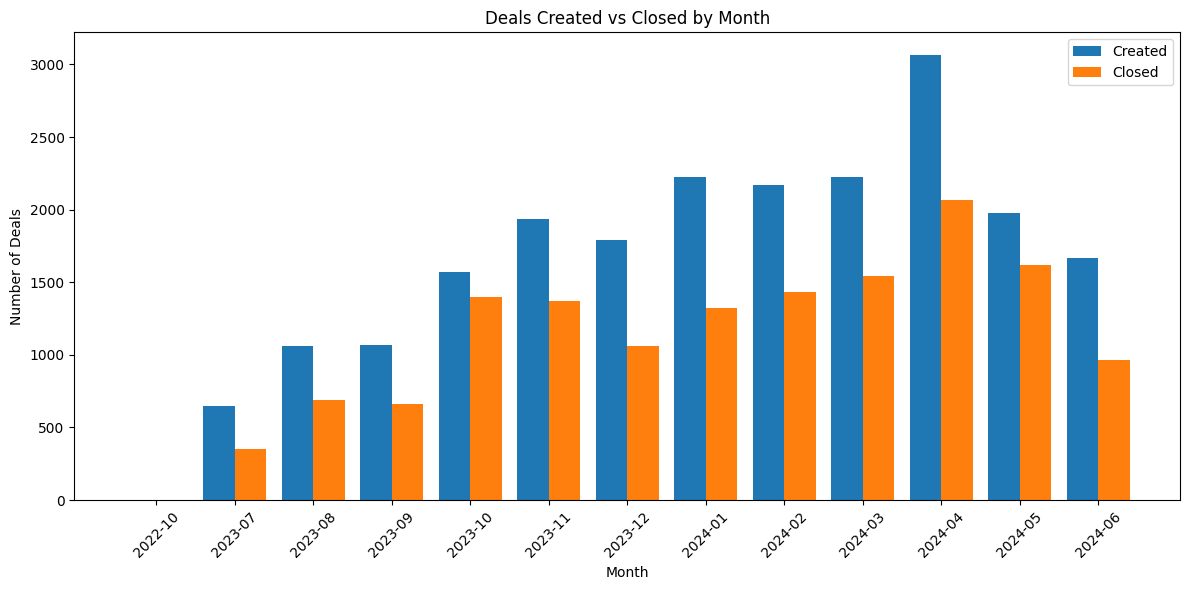

In [7]:
# Set the size of the figure
plt.figure(figsize=(12, 6))

# Positions of the bars on the x-axis
x = np.arange(len(summary.index))

# Width of each bar
width = 0.4

# Plot bars for Created and Closed deals
plt.bar(x - width/2, summary['Created'], width=width, label='Created', color='#1f77b4')
plt.bar(x + width/2, summary['Closed'], width=width, label='Closed', color='#ff7f0e')

# Labels and title
plt.xlabel('Month')
plt.ylabel('Number of Deals')
plt.title('Deals Created vs Closed by Month')
plt.xticks(ticks=x, labels=[str(month) for month in summary.index], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

Trend of Deal Creation Over Time and Its Relationship with Calls

      Month   Deals    Calls
0   2022-10     1.0      0.0
1   2023-06     0.0      7.0
2   2023-07   648.0   1923.0
3   2023-08  1063.0   4090.0
4   2023-09  1067.0   4978.0
5   2023-10  1568.0   6903.0
6   2023-11  1935.0   7009.0
7   2023-12  1792.0   6983.0
8   2024-01  2226.0   9609.0
9   2024-02  2169.0   9374.0
10  2024-03  2228.0   9556.0
11  2024-04  3068.0  12767.0
12  2024-05  1978.0  11369.0
13  2024-06  1668.0   8049.0


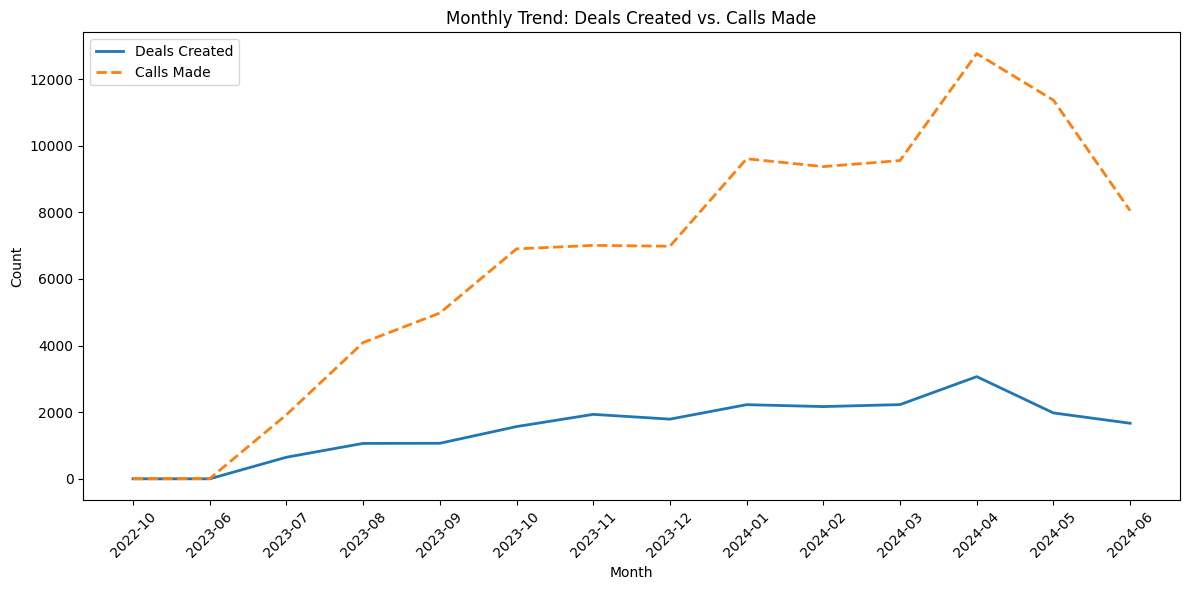

In [8]:
# Group deals by month using the period 'M' for monthly aggregation
deals_by_month = (
    deals.groupby(deals["Created Time"].dt.to_period("M"))  # Group by month period
    .size()  # Count the number of deals per month
    .rename("Deals")  # Rename the resulting series for clarity
    .reset_index()  # Convert back to a DataFrame
)

# Convert the Period objects to string for easier plotting and display
deals_by_month["Created Time"] = deals_by_month["Created Time"].astype(str)

# Group calls by month in the same way
calls_by_month = (
    calls.groupby(calls["Call Start Time"].dt.to_period("M"))
    .size()
    .rename("Calls")
    .reset_index()
)

calls_by_month["Call Start Time"] = calls_by_month["Call Start Time"].astype(str)

# Merge the deals and calls data on the month column to align counts by month
activity_monthly = pd.merge(
    deals_by_month.rename(columns={"Created Time": "Month"}),
    calls_by_month.rename(columns={"Call Start Time": "Month"}),
    on="Month",
    how="outer"  # Keep all months that appear in either dataset
).fillna(0)  # Replace missing values with zero, meaning no activity that month

# Sort the data by month to ensure the plot follows chronological order
activity_monthly = activity_monthly.sort_values("Month")
print(activity_monthly)

# Plot the trends for deals created and calls made over time
plt.figure(figsize=(12, 6))
plt.plot(activity_monthly["Month"], activity_monthly["Deals"], label="Deals Created", linewidth=2)
plt.plot(activity_monthly["Month"], activity_monthly["Calls"], label="Calls Made", linewidth=2, linestyle="--")

# Add titles and labels to the plot for clarity
plt.title("Monthly Trend: Deals Created vs. Calls Made")
plt.xlabel("Month")
plt.ylabel("Count")

# Rotate the x-axis labels so they don't overlap and are easier to read
plt.xticks(rotation=45)

# Add a legend to distinguish the two lines
plt.legend()

# Adjust layout to prevent clipping of labels and titles
plt.tight_layout()

plt.show()

The monthly trend between calls made and deals created shows a strong and consistent correlation, highlighting the impact of outreach efforts on pipeline generation.

For instance:

In April 2024, the highest number of deals (3,068) was recorded, coinciding with the highest call volume (12,767 calls).

Similarly, in January–March 2024, when call volumes ranged from 9,374 to 9,609, deal creation also remained high, with each month exceeding 2,100 deals.

In contrast:

June 2023 recorded only 7 calls and 0 deals, while October 2022 had 1 deal and no calls, reinforcing the idea that minimal calling activity leads to little or no deal creation.

Looking at the overall period:

The average number of calls per month was approximately 6,062.

The average number of deals per month was approximately 1,644.

Months with above-average call volumes (e.g., October 2023 to April 2024) consistently yielded above-average deal counts, with some months like November 2023 and March 2024 producing over 1,900 and 2,200 deals, respectively.

This pattern clearly demonstrates that increased call activity contributes directly to greater deal volume. Maintaining high and consistent call outreach is therefore critical to sustaining momentum in deal creation and overall revenue pipeline growth.

Distribution of Deal Closing Times and Duration Between Creation and Closure

   Closing Month  Closed Deals
0        2023-07           352
1        2023-08           692
2        2023-09           660
3        2023-10          1400
4        2023-11          1369
5        2023-12          1061
6        2024-01          1324
7        2024-02          1434
8        2024-03          1543
9        2024-04          2070
10       2024-05          1622
11       2024-06           966
12       2024-09             1
13       2024-12             1


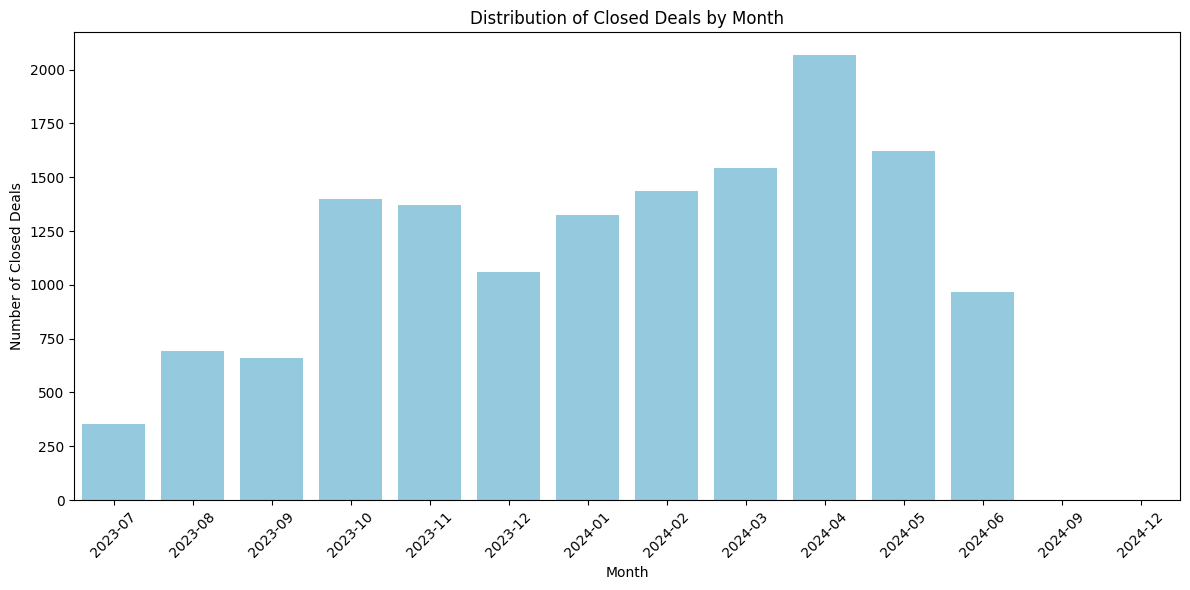

In [9]:
# Filter deals that have a closing date (i.e., closed deals)
closed_deals = deals.dropna(subset=['Closing Date']).copy()

# Create a column with the closing month (format 'YYYY-MM')
closed_deals['Closing Month'] = closed_deals['Closing Date'].dt.to_period('M').astype(str)

# Count the number of closed deals per month
closed_counts = closed_deals.groupby('Closing Month').size().reset_index(name='Closed Deals')
print(closed_counts)

# Visualize the distribution of closed deals by month
plt.figure(figsize=(12,6))
sns.barplot(data=closed_counts, x='Closing Month', y='Closed Deals', color='skyblue')

plt.xticks(rotation=45)
plt.title('Distribution of Closed Deals by Month')
plt.xlabel('Month')
plt.ylabel('Number of Closed Deals')
plt.tight_layout()
plt.show()

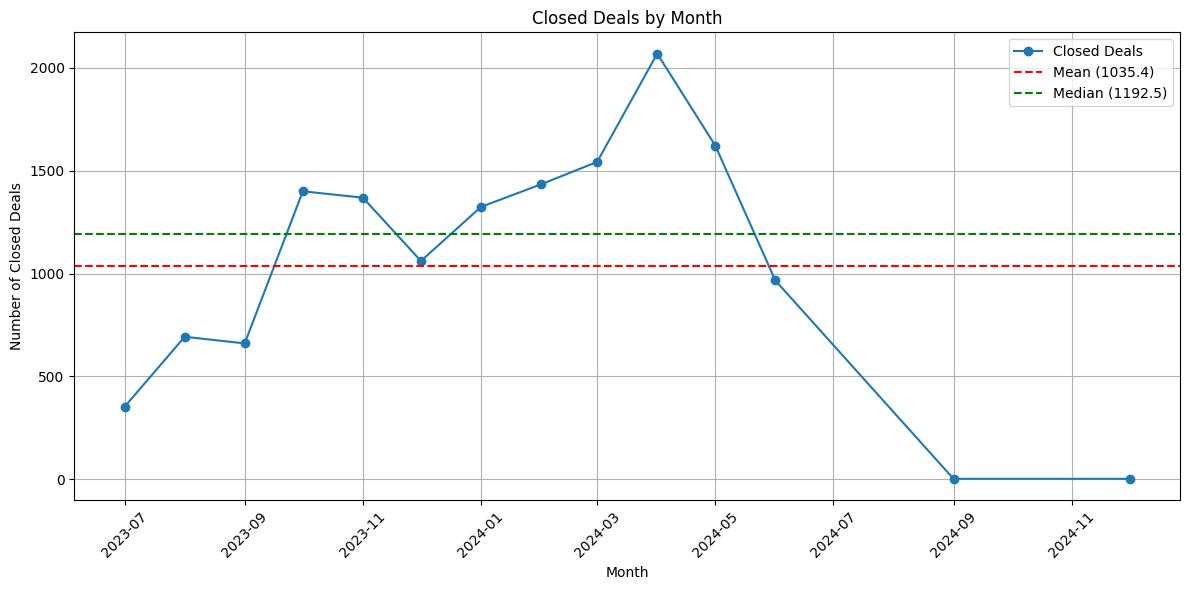

Average number of closed deals: 1035.357142857143
Median number of closed deals: 1192.5

Anomalies in data:
   Closing Month  Closed Deals  Deals Change  Deals Change %
12    2024-09-01             1        -965.0       -99.89648
13    2024-12-01             1           0.0         0.00000


In [10]:
# Initial data
data = {
    'Closing Month': [
        '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12',
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-09', '2024-12'
    ],
    'Closed Deals': [
        352, 692, 660, 1400, 1369, 1061, 1324, 1434, 1543, 2070, 1622, 966, 1, 1
    ]
}

df = pd.DataFrame(data)
df['Closing Month'] = pd.to_datetime(df['Closing Month'])
df = df.sort_values('Closing Month')

# Basic metrics
mean_deals = df['Closed Deals'].mean()
median_deals = df['Closed Deals'].median()

# Calculate deals change compared to previous month
df['Deals Change'] = df['Closed Deals'].diff()
df['Deals Change %'] = df['Closed Deals'].pct_change() * 100

# Identify anomalies (e.g., deals less than 10 or sharp drop)
anomalies = df[(df['Closed Deals'] < 10) | (df['Deals Change %'] < -50)]

# Visualization
plt.figure(figsize=(12,6))
plt.plot(df['Closing Month'], df['Closed Deals'], marker='o', label='Closed Deals')
plt.axhline(mean_deals, color='r', linestyle='--', label=f'Mean ({mean_deals:.1f})')
plt.axhline(median_deals, color='g', linestyle='--', label=f'Median ({median_deals:.1f})')
plt.title('Closed Deals by Month')
plt.xlabel('Month')
plt.ylabel('Number of Closed Deals')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Average number of closed deals:", mean_deals)
print("Median number of closed deals:", median_deals)
print("\nAnomalies in data:")
print(anomalies)

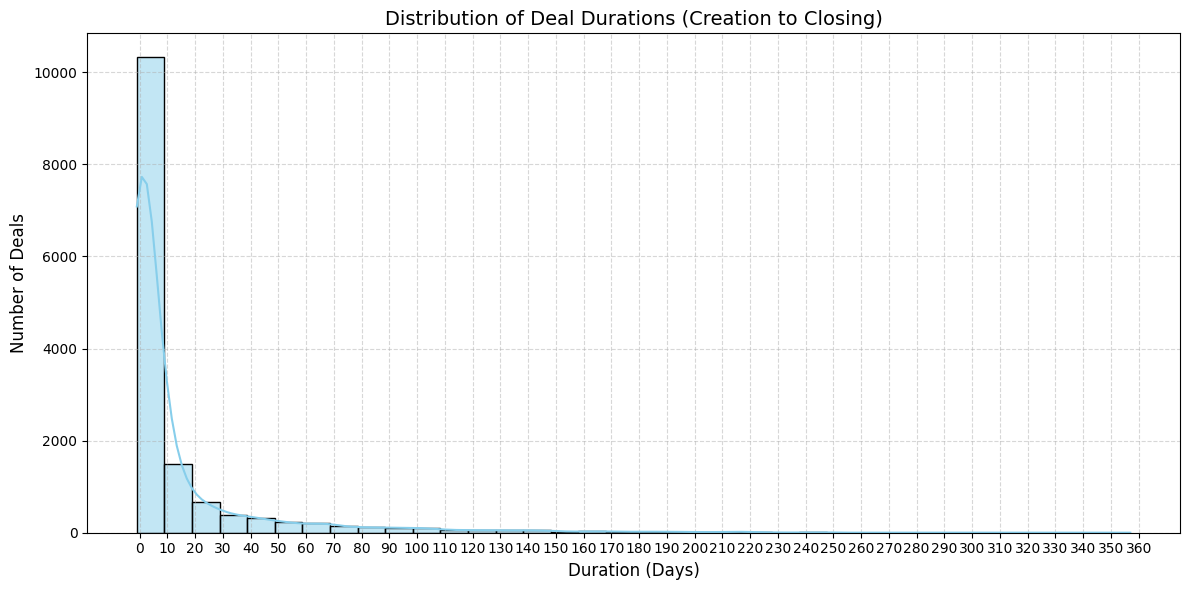

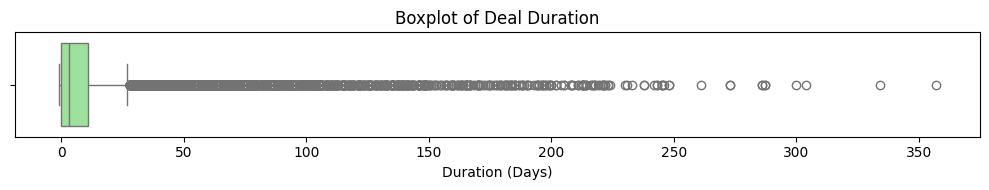

In [11]:
# Keep only deals that have a closing date
closed_deals = deals[deals["Closing Date"].notna()].copy()

# Calculate the number of days between creation and closing
closed_deals["Duration (days)"] = (closed_deals["Closing Date"] - closed_deals["Created Time"]).dt.days

# Plot a histogram of the deal durations
plt.figure(figsize=(12, 6))
sns.histplot(
    data=closed_deals,
    x="Duration (days)",
    binwidth=10,       # group durations in 10-day intervals
    kde=True,
    color="skyblue"
)

# Set x-axis ticks every 10 days
max_duration = closed_deals["Duration (days)"].max()
plt.xticks(np.arange(0, max_duration + 10, 10))

plt.title("Distribution of Deal Durations (Creation to Closing)", fontsize=14)
plt.xlabel("Duration (Days)", fontsize=12)
plt.ylabel("Number of Deals", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Boxplot to show spread and outliers in deal durations
plt.figure(figsize=(10, 2))
sns.boxplot(data=closed_deals, x="Duration (days)", color="lightgreen")
plt.title("Boxplot of Deal Duration", fontsize=12)
plt.xlabel("Duration (Days)")
plt.tight_layout()
plt.show()

📊 Analysis of Deal Duration (from creation to closing)
✅ Key Statistics:
Total closed deals analyzed: 14,495

Mean duration: ~14.2 days

Median (50%) duration: 3 days

25% of deals closed on the same day or next day (0 days or less)

75% of deals were closed within 11 days

Maximum duration: 357 days

Minimum duration: -1 day (likely data quality issue)

Standard deviation: 31.8 days (high variation suggests outliers or long-tail cases)

📈 Distribution of Deal Durations:
Fast Closures (0–10 days):

5,714 deals (~39% of all) were closed within 10 days

Moderate Duration (10–30 days):

Additional 1,831 deals (~12.6%) closed between 10 and 30 days

Long Duration (30–100 days):

1,228 deals (~8.5%)

Very Long Duration (>100 days):

Only 491 deals (just ~3.4%) took longer than 100 days

Very few extended past 200+ days

📌 Insights & Recommendations:
Most deals are closed quickly:
Over 50% of all deals are finalized within just 3 days of creation, and nearly 75% are closed within 11 days. This indicates an efficient sales process for the majority of leads.

There are extreme outliers:
A small number of deals took over 100 to 350+ days. These may represent:

Complex sales cycles

Dormant leads that were later reactivated

Possible data entry issues (especially the -1 day value)

Data Cleaning Needed:
The minimum value of -1 day is likely an error (e.g., closing date before creation). These should be investigated or filtered out in future analysis.

Segment deals by duration for sales strategy:
Categorizing deals into fast, moderate, and long-cycle can help optimize pipeline forecasting and identify bottlenecks.

Campaign Effectiveness Analysis

Compare the effectiveness of different campaigns in terms of lead generation and conversion rates.

In [13]:
# Filter out deals with 'Unknown' campaign and count unique deal IDs per campaign
campaign_deals = deals[deals['Campaign'] != 'Unknown']\
    .groupby('Campaign', observed=True)['Contact Name']\
    .nunique().reset_index(name='Total Deals')

# Count successful deals (where stage is 'Payment Done') per campaign
successful_campaign_deals = deals[
    (deals['Stage'] == 'Payment Done') & (deals['Campaign'] != 'Unknown')]\
    .groupby('Campaign', observed=True)['Contact Name']\
    .nunique().reset_index(name='Successful Deals')

# Sum total revenue per campaign for successful deals only
total_sales_campaign = deals[
    (deals['Stage'] == 'Payment Done') & (deals['Campaign'] != 'Unknown')]\
    .groupby('Campaign', observed=True)['Offer Total Amount']\
    .sum().reset_index()

# Merge the metrics into a single DataFrame
campaign_performance = pd.merge(campaign_deals, successful_campaign_deals,
                                on='Campaign', how='left')
campaign_performance = pd.merge(campaign_performance, total_sales_campaign,
                                on='Campaign', how='left')

# Fill missing values with 0 (e.g., if there were no successful deals or sales for a campaign)
campaign_performance['Successful Deals'] = campaign_performance['Successful Deals'].fillna(0)
campaign_performance['Offer Total Amount'] = campaign_performance['Offer Total Amount'].fillna(0)

# Calculate conversion rate as a percentage
campaign_performance['Conversion Rate'] = (
    campaign_performance['Successful Deals'] / campaign_performance['Total Deals']) * 100

# Sort by number of successful deals descending
campaign_performance_sorted = campaign_performance.sort_values(
    by='Successful Deals', ascending=False)

# Rename columns for output
campaign_performance_sorted.columns = [
    'Campaign', 'Total Deals', 'Successful Deals',
    'Offer Total Amount', 'Conversion Rate']

# Format and display the table
formatted_campaign_performance_sorted = campaign_performance_sorted[
    ['Campaign', 'Total Deals', 'Successful Deals',
     'Offer Total Amount', 'Conversion Rate']].style.format({
    'Successful Deals': '{:,.0f}',
    'Offer Total Amount': '{:,.0f}',
    'Conversion Rate': '{:.2f}'
}).hide(axis='index')

display(formatted_campaign_performance_sorted)

Campaign,Total Deals,Successful Deals,Offer Total Amount,Conversion Rate
performancemax_digitalmarkt_ru_DE,2508,371,"3,344,400",14.79
12.07.2023wide_DE,1505,226,"2,058,900",15.02
youtube_shorts_DE,1520,218,"2,009,200",14.34
02.07.23wide_DE,943,181,"1,638,600",19.19
12.09.23interests_Uxui_DE,516,131,"1,222,300",25.39
Dis_DE,562,131,"1,229,300",23.31
04.07.23recentlymoved_DE,738,126,"1,140,900",17.07
03.07.23women,600,117,"1,158,798",19.50
07.07.23LAL_DE,529,109,"1,057,000",20.60
24.09.23retargeting_DE,471,98,"971,500",20.81


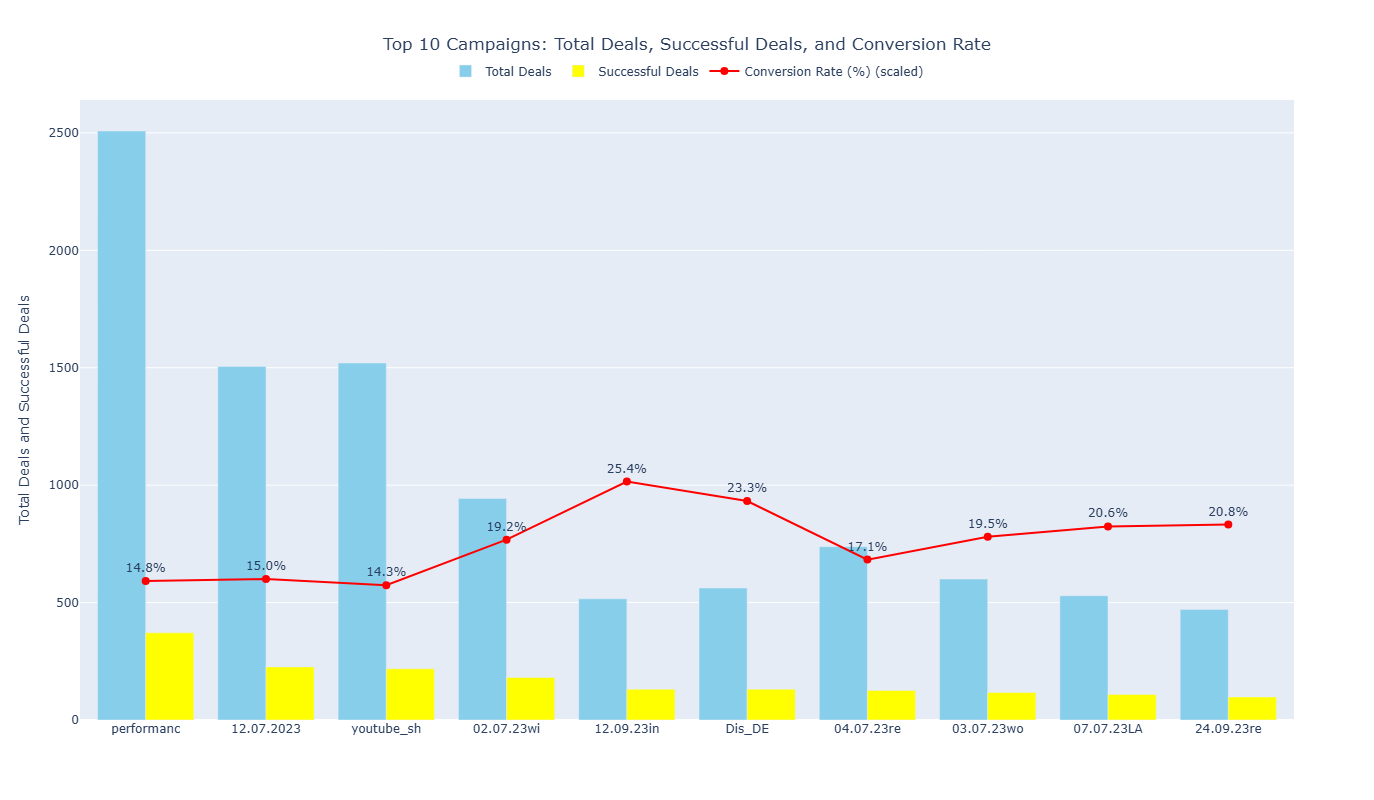

In [14]:
# Graph for Top 10 Campaigns
top_10_campaigns = campaign_performance_sorted.head(10)
top_10_campaigns_cleaned = top_10_campaigns.copy()
top_10_campaigns_cleaned['Campaign'] = top_10_campaigns_cleaned['Campaign'].str[:10]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_10_campaigns_cleaned['Campaign'],
    y=top_10_campaigns_cleaned['Total Deals'],
    name='Total Deals',
    marker_color='skyblue'
))

fig.add_trace(go.Bar(
    x=top_10_campaigns_cleaned['Campaign'],
    y=top_10_campaigns_cleaned['Successful Deals'],
    name='Successful Deals',
    marker_color='yellow'
))

scaled_conversion_rate = [rate * 40 for rate in top_10_campaigns_cleaned['Conversion Rate']]

fig.add_trace(go.Scatter(
    x=top_10_campaigns_cleaned['Campaign'],
    y=scaled_conversion_rate,
    mode='lines+markers+text',
    name='Conversion Rate (%) (scaled)',
    text=[f'{rate:.1f}%' for rate in top_10_campaigns_cleaned['Conversion Rate']],
    textposition='top center',
    marker=dict(color='red', size=8),
    line=dict(color='red', width=2)
))

fig.update_layout(
    title=dict(
        text='Top 10 Campaigns: Total Deals, Successful Deals, and Conversion Rate',
        x=0.5, xanchor='center'
    ),
    xaxis_title='',
    yaxis_title='Total Deals and Successful Deals',
    yaxis2=dict(title='Conversion Rate (%)', overlaying='y', side='right'),
    legend=dict(x=0.5, y=1.07, xanchor='center', orientation='h'),
    barmode='group',
    xaxis_tickangle=0,
    height=800,
    width=1200
)

fig.show() 

Key Insights from Campaign Performance Analysis
1. Top-Performing Campaigns by Volume
performancemax_digitalmarkt_ru_DE generated the highest number of total deals (2,633) and successful deals (376), with over €3.3M in revenue, though its conversion rate was a modest 14.28%.

Campaigns such as 12.07.2023wide_DE and youtube_shorts_DE also performed strongly in volume, each with over 200 successful deals and €2M+ revenue.

2. Highest Conversion Rates
The best conversion rates were achieved by:

web1312_DE — 54.55%

gen_analyst_DE — 37.14%

Trigger_DE — 35.14%

18.10.23wide_gos_DE — 35.71%

These campaigns had relatively low volume but demonstrated high efficiency in converting leads into paying clients.

3. Strong ROI Campaigns (High Revenue per Deal)
Campaigns with strong financial impact per conversion:

brand_search_eng_DE: 58 deals → €523,000 → €9,017 per deal

Live_DE: 9 deals → €86,500 → €9,611 per deal

Several small campaigns (e.g. col_DE, mail_DE, ggg10_DE) had few successful deals but each deal brought in ~€11,000, showing high unit value.

4. Underperforming Campaigns
A large number of campaigns (over 60) generated no successful deals, despite having dozens or even hundreds of total leads (e.g., 08.06.24wide_webinar_DE with 112 leads and 0 conversions).

These campaigns may reflect:

Misaligned targeting

Poor ad creative or landing pages

Low lead quality

5. Webinar & Test Campaigns Mostly Ineffective
Campaigns labeled as webinar or test often showed very low conversion rates, suggesting issues with webinar engagement or test design. Examples:

webinar1604: 342 deals → 7 successes → 2.05%

webinar1906: 290 deals → 4 successes → 1.38%

08.04.24wide_webinar_DE: 284 deals → 5 successes → 1.76%

✅ Recommendations
Scale High-Converting Campaigns: Campaigns with high conversion rates (above 30%) should be considered for further scaling, even if their volume is currently small.

Audit and Pause Ineffective Campaigns: Campaigns with 0 successful deals and moderate to high spend volumes should be paused or restructured.

Optimize Webinar Funnels: Webinars consistently underperform; consider improving content, promotion methods, or follow-up nurturing.

Leverage High-Value Channels: Campaigns with high average deal size—even at lower volume—should be further explored to replicate their quality.



Source Performance: Leads and Conversion Rate

In [15]:
spend[['Campaign', 'Source']] = spend[['Campaign', 'Source']].astype('category')
deals_spend = pd.merge(deals, spend, on='Campaign', how='outer')
deals_spend.info()     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10072990 entries, 0 to 10072989
Data columns (total 27 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Id                   object        
 1   Deal Owner Name      object        
 2   Closing Date         datetime64[ns]
 3   Quality              object        
 4   Stage                object        
 5   Lost Reason          object        
 6   Campaign             object        
 7   Source_x             object        
 8   Payment Type         object        
 9   Product              object        
 10  Education Type       object        
 11  Created Time         datetime64[ns]
 12  Course duration      float64       
 13  Months of study      float64       
 14  Initial Amount Paid  float64       
 15  Offer Total Amount   float64       
 16  Contact Name         object        
 17  City                 object        
 18  Level of Deutsch     object        
 19  SLA in Seconds     

In [16]:
source_leads = deals_spend[deals_spend['Source_y'] != 'Test'].groupby('Source_y', observed=True).size().reset_index(name='Leads')
source_leads     

,Source_y,Leads
0,Bloggers,277
1,CRM,315
2,Facebook Ads,4995410
3,Google Ads,155846
4,Offline,16
5,Organic,502
6,Partnership,105
7,Radio,6
8,SMM,479
9,Telegram posts,481


In [17]:
spend['Source'].value_counts()

Source
Facebook Ads      9195
Tiktok Ads        2200
Youtube Ads       1429
Google Ads         911
Organic            502
Telegram posts     481
SMM                479
CRM                315
Webinar            308
Bloggers           277
Test               169
Partnership        105
Offline             16
Radio                6
Name: count, dtype: int64

In [18]:
successful_deals = deals_spend[(deals_spend['Source_y'] != 'Test')
                             & (deals_spend['Stage'] == 'Payment Done')\
                               ].groupby('Source_y', observed=True).size().reset_index(name='Successful Deals')

successful_deals

,Source_y,Successful Deals
0,Facebook Ads,975191
1,Google Ads,20169
2,Tiktok Ads,411879
3,Webinar,1641
4,Youtube Ads,267837


In [19]:
source_performance = pd.merge(source_leads, successful_deals, on='Source_y',
                              how='outer')

source_performance['Successful Deals'] = source_performance[
                        'Successful Deals'].fillna(0)
source_performance['Conversion Rate'] = source_performance[
                        'Successful Deals'] /source_performance['Leads'] * 100
source_performance
     

,Source_y,Leads,Successful Deals,Conversion Rate
0,Bloggers,277,0.0,0.000000
1,CRM,315,0.0,0.000000
2,Facebook Ads,4995410,975191.0,19.521741
3,Google Ads,155846,20169.0,12.941622
4,Offline,16,0.0,0.000000
5,Organic,502,0.0,0.000000
6,Partnership,105,0.0,0.000000
7,Radio,6,0.0,0.000000
8,SMM,479,0.0,0.000000
9,Telegram posts,481,0.0,0.000000


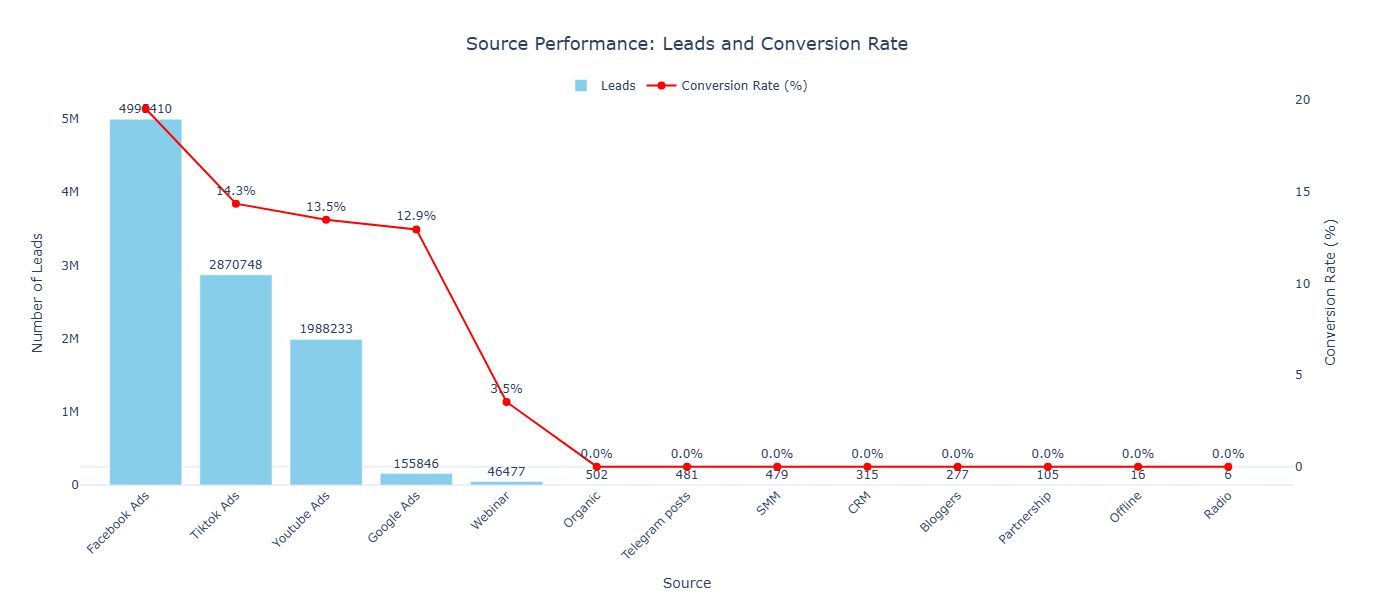

In [20]:
fig = go.Figure()

source_performance = source_performance.sort_values(
    by='Leads', ascending=False)

fig.add_trace(go.Bar(
    x=source_performance['Source_y'],
    y=source_performance['Leads'],
    name='Leads',
    marker_color='skyblue',
    text=source_performance['Leads'],
    textposition='outside'
))

fig.add_trace(go.Scatter(
    x=source_performance['Source_y'],
    y=source_performance['Conversion Rate'],
    name='Conversion Rate (%)',
    mode='lines+markers+text',
    text=[f"{y:.1f}%" for y in source_performance['Conversion Rate']],
    textposition='top center',
    marker=dict(color='red', size=8),
    line=dict(color='red', width=2, dash='solid'),
    yaxis='y2'
))

fig.update_layout(
    title=dict(
        text="Source Performance: Leads and Conversion Rate",
        x=0.5,
        xanchor="center",
        font=dict(size=18)
    ),
    xaxis=dict(title="Source", tickangle=-45),
    yaxis=dict(title="Number of Leads", showgrid=False),
    yaxis2=dict(
        title="Conversion Rate (%)",
        overlaying='y',
        side='right',
        showgrid=False,
        range=[-1, 20]
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1,
        xanchor="center",
        x=0.5
    ),
    height=600,
    width=1000,
    template="plotly_white"
)

fig.show()

Insights:
The highest number of leads comes from Facebook Ads (4.99M), TikTok Ads (2.87M), and YouTube Ads (1.98M).
The highest conversion rates are observed for Facebook Ads (19.52%), YouTube Ads (13.5%), and TikTok Ads (14.3%).
Google Ads (155K leads) has a conversion rate (12.94%), which is lower than the top 3 sources.
Other sources generate few leads, and Telegram, Bloggers, Organic, SMM, CRM, Partnership, Offline, and Radio show 0% conversion.
Conclusion: It is worth focusing on Facebook, TikTok, and YouTube Ads as the most effective acquisition channels.


In [21]:
filtered_sources = [
    "Facebook Ads", "Tiktok Ads", "Youtube Ads", "Google Ads", "Webinar"
                   ]
filtered_deals = deals_spend[deals_spend['Source_y']\
                             .astype(str).isin(filtered_sources)]
filtered_deals['Source_y'].value_counts()

Source_y
Facebook Ads      4995410
Tiktok Ads        2870748
Youtube Ads       1988233
Google Ads         155846
Webinar             46477
CRM                     0
Organic                 0
Offline                 0
Bloggers                0
Partnership             0
Telegram posts          0
SMM                     0
Radio                   0
Test                    0
Name: count, dtype: int64

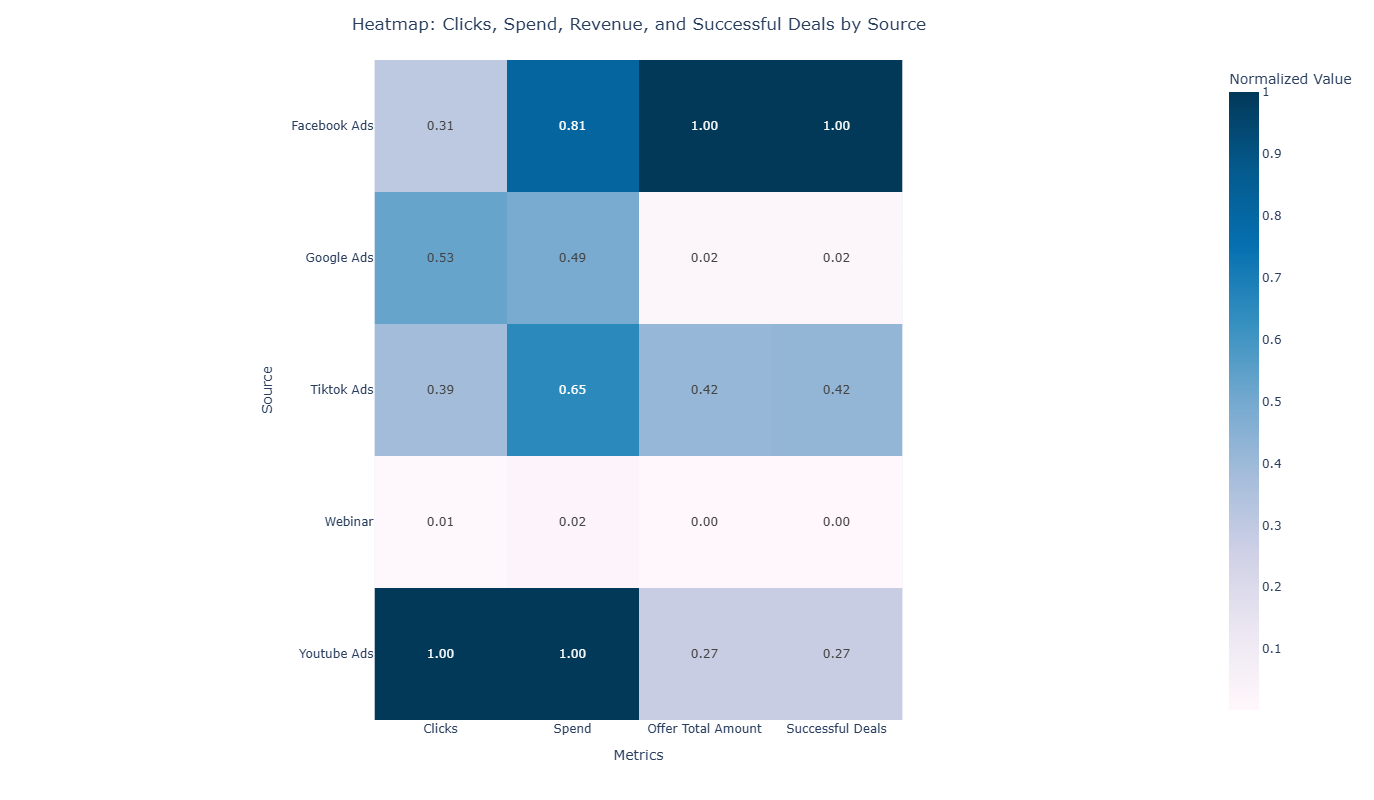

In [22]:
filtered_df = deals_spend[deals_spend['Source_y'].isin(filtered_sources)]

heatmap_data = filtered_df.groupby('Source_y', observed=False).agg({
    'Clicks': 'sum',
    'Spend': 'sum',
    'Offer Total Amount': 'sum',
    'Stage': lambda x: (x == 'Payment Done').sum()
}).rename(columns={'Stage': 'Successful Deals'}).reset_index()

heatmap_data = heatmap_data[heatmap_data['Source_y'].isin(filtered_sources)]

cols = ['Clicks', 'Spend', 'Offer Total Amount', 'Successful Deals']
heatmap_data[cols] = heatmap_data[cols].astype(float)

heatmap_data.set_index('Source_y', inplace=True)
heatmap_data_normalized = heatmap_data / heatmap_data.max()

fig = px.imshow(
    heatmap_data_normalized,
    labels=dict(x="Metrics", y="Source", color="Normalized Value"),
    x=heatmap_data_normalized.columns,
    y=heatmap_data_normalized.index,
    color_continuous_scale="PuBu",
    text_auto=".2f"
)

fig.update_layout(
    title=dict(
        text="Heatmap: Clicks, Spend, Revenue, and Successful Deals by Source",
        x=0.465,
        xanchor="center"
    ),
    xaxis_title="Metrics",
    yaxis_title="Source",
    width=1200,
    height=800,
    xaxis=dict(tickangle=0)
)

fig.show()
     

In [23]:
print(heatmap_data_normalized)

                Clicks     Spend  Offer Total Amount  Successful Deals
Source_y                                                              
Facebook Ads  0.306646  0.811862            1.000000          1.000000
Google Ads    0.527231  0.489450            0.019608          0.020682
Tiktok Ads    0.385058  0.654144            0.416321          0.422357
Webinar       0.005344  0.022087            0.001618          0.001683
Youtube Ads   1.000000  1.000000            0.273568          0.274651


**Campaign Performance Analysis Overview**

An analysis of the "deals" dataset was conducted to evaluate the performance of various advertising sources based on clicks, spend, offer total amount, and successful deals. The following report highlights key insights, top-performing sources, cost-efficiency metrics, and actionable recommendations for optimization.

**Key Insights from Advertising Source Performance Analysis**

**✅ Top-Performing Source**  
- **Facebook Ads** achieved the highest performance in both revenue generation (100% of the maximum Offer Total Amount) and conversions (100% of the maximum Successful Deals). Despite a relatively low click share (30.66% of the maximum), it demonstrates exceptional efficiency, indicating high-quality leads.

**⚖️ Cost vs. Performance Balance**  
- **Facebook Ads**: High spend, high value (Offer Total Amount and Successful Deals), indicating efficient spend with strong ROI.  
- **Google Ads**: Medium spend, very low value, with high click share but poor conversion.  
- **Tiktok Ads**: Medium spend, medium value, showing a balanced cost and return.  
- **Webinar**: Very low spend, very low value, with minimal investment and impact.  
- **YouTube Ads**: High spend, medium value, offering high visibility but moderate ROI.

**📈 Conversion Efficiency**  
A custom metric, Conversion Efficiency (Successful Deals / Spend), was calculated to evaluate return on ad spend:  
- Facebook Ads: 1.23  
- Tiktok Ads: 0.65  
- YouTube Ads: 0.27  
- Webinar: 0.08  
- Google Ads: 0.04  

- **Facebook Ads** leads with the highest efficiency, delivering significantly more conversions relative to its spend.  
- **Google Ads** shows the lowest efficiency, with high clicks but minimal conversions.

**🧠 Recommendations**  
1. **Scale Facebook Ads**: Its high efficiency and strong ROI make it a prime candidate for increased investment.  
2. **Re-evaluate Google Ads**: Despite high clicks (52.72% of the maximum), its poor conversion rate (0.04 efficiency) suggests issues with targeting or ad creatives that need refinement.  
3. **Monitor Tiktok Ads**: With a balanced spend and decent conversion efficiency (0.65), this source has potential for scaling if optimized further.  
4. **Limit Webinar Investment**: Very low spend and impact (0.08 efficiency) indicate minimal returns; consider pausing or restructuring.  
5. **Audit YouTube Ads**: High spend and clicks (100% of the maximum) but moderate conversions (0.27 efficiency) suggest a need to optimize the conversion funnel or explore retargeting strategies.

**Suggested Additional Analysis**  
- **Cost Per Successful Deal**: Calculate Spend / Successful Deals to identify the cost-effectiveness of each source. For example, Facebook Ads’ high efficiency suggests a lower cost per deal compared to Google Ads.  
- **Click-to-Conversion Ratio**: Analyze Successful Deals / Clicks to better understand lead quality across sources.  
- **Time-Based Trends**: If temporal data is available, examine performance trends over time to identify seasonality or campaign fatigue.  
- **Audience Segmentation**: If demographic or geographic data exists, analyze which audience segments drive conversions for each source to refine targeting.

Sales Team Performance Analysis

In [24]:
# Count total number of deals handled by each deal owner
owner_deals = deals.groupby('Deal Owner Name', observed=True)['Id']\
                   .nunique().reset_index(name='Total Deals')

# Count number of successful deals (deals at 'Payment Done' stage) per owner
successful_owner_deals = (
    deals[deals['Stage'] == 'Payment Done']
    .groupby('Deal Owner Name', observed=True)['Id']
    .nunique()
    .reset_index(name='Successful Deals')
)

# Calculate total payment amount for successful deals per owner
total_sales = (
    deals[deals['Stage'] == 'Payment Done']
    .groupby('Deal Owner Name', observed=True)['Offer Total Amount']
    .sum().reset_index()
)

In [25]:
# Merge all calculated dataframes on 'Deal Owner Name'
owner_performance = pd.merge(owner_deals, successful_owner_deals,
                             on='Deal Owner Name', how='left')

owner_performance = pd.merge(owner_performance, total_sales,
                             on='Deal Owner Name', how='left')

# Fill missing values (owners with 0 successful deals or sales)
owner_performance['Successful Deals'] = owner_performance['Successful Deals'].fillna(0)
owner_performance['Offer Total Amount'] = owner_performance['Offer Total Amount'].fillna(0)

# Calculate conversion rate: successful deals / total deals * 100%
owner_performance['Conversion Rate'] = (
    owner_performance['Successful Deals'] / owner_performance['Total Deals'] * 100
)

# Sort by number of successful deals in descending order
owner_performance_sorted = owner_performance.sort_values(
    by='Successful Deals', ascending=False
)

# Rename columns for clarity
owner_performance_sorted.columns = [
    'Deal Owner Name', 'Total Deals', 'Successful Deals',
    'Offer Total Amount', 'Conversion Rate'
]

# Format the result table for better readability
formatted_owner_performance_sorted = owner_performance_sorted[
    ['Deal Owner Name', 'Total Deals', 'Successful Deals',
     'Offer Total Amount', 'Conversion Rate']
].style.format({
    'Successful Deals': '{:,.0f}',
    'Offer Total Amount': '{:,.0f}',
    'Conversion Rate': '{:.2f}'
}).hide(axis='index')

# Display the styled table
display(formatted_owner_performance_sorted)

Deal Owner Name,Total Deals,Successful Deals,Offer Total Amount,Conversion Rate
Ulysses Adams,2150,565,"5,029,900",26.28
Charlie Davis,2929,437,"3,821,000",14.92
Julia Nelson,2196,391,"3,576,811",17.81
Paula Underwood,1855,327,"2,836,500",17.63
Victor Barnes,1229,251,"2,255,500",20.42
Ben Hall,1344,242,"1,986,900",18.01
Nina Scott,1280,216,"1,943,000",16.88
Quincy Vincent,1878,203,"1,779,000",10.81
Oliver Taylor,163,153,"1,660,500",93.87
Jane Smith,981,144,"1,468,500",14.68


In [26]:
# 25th percentile (Q1) for total deals
Q1_T = owner_performance['Total Deals'].quantile(0.25)

# Keep only owners above Q1 in total deals
owner_performance_f_deals = owner_performance[
    owner_performance['Total Deals'] > Q1_T
]

# Keep only owners who have at least 1 successful deal
owner_performance_f_deals = owner_performance_f_deals[
    owner_performance_f_deals['Successful Deals'] > 0
]

# Compute 25th percentile (Q1) for successful deals
Q1_S = owner_performance_f_deals['Successful Deals'].quantile(0.25)

# Keep only owners above Q1 in successful deals
owner_performance_f_deals = owner_performance_f_deals[
    owner_performance_f_deals['Successful Deals'] > Q1_S
]

# Sort the remaining owners by conversion rate in descending order
owner_performance_f_deals_conversion = owner_performance_f_deals.sort_values(
    by='Conversion Rate', ascending=False
)

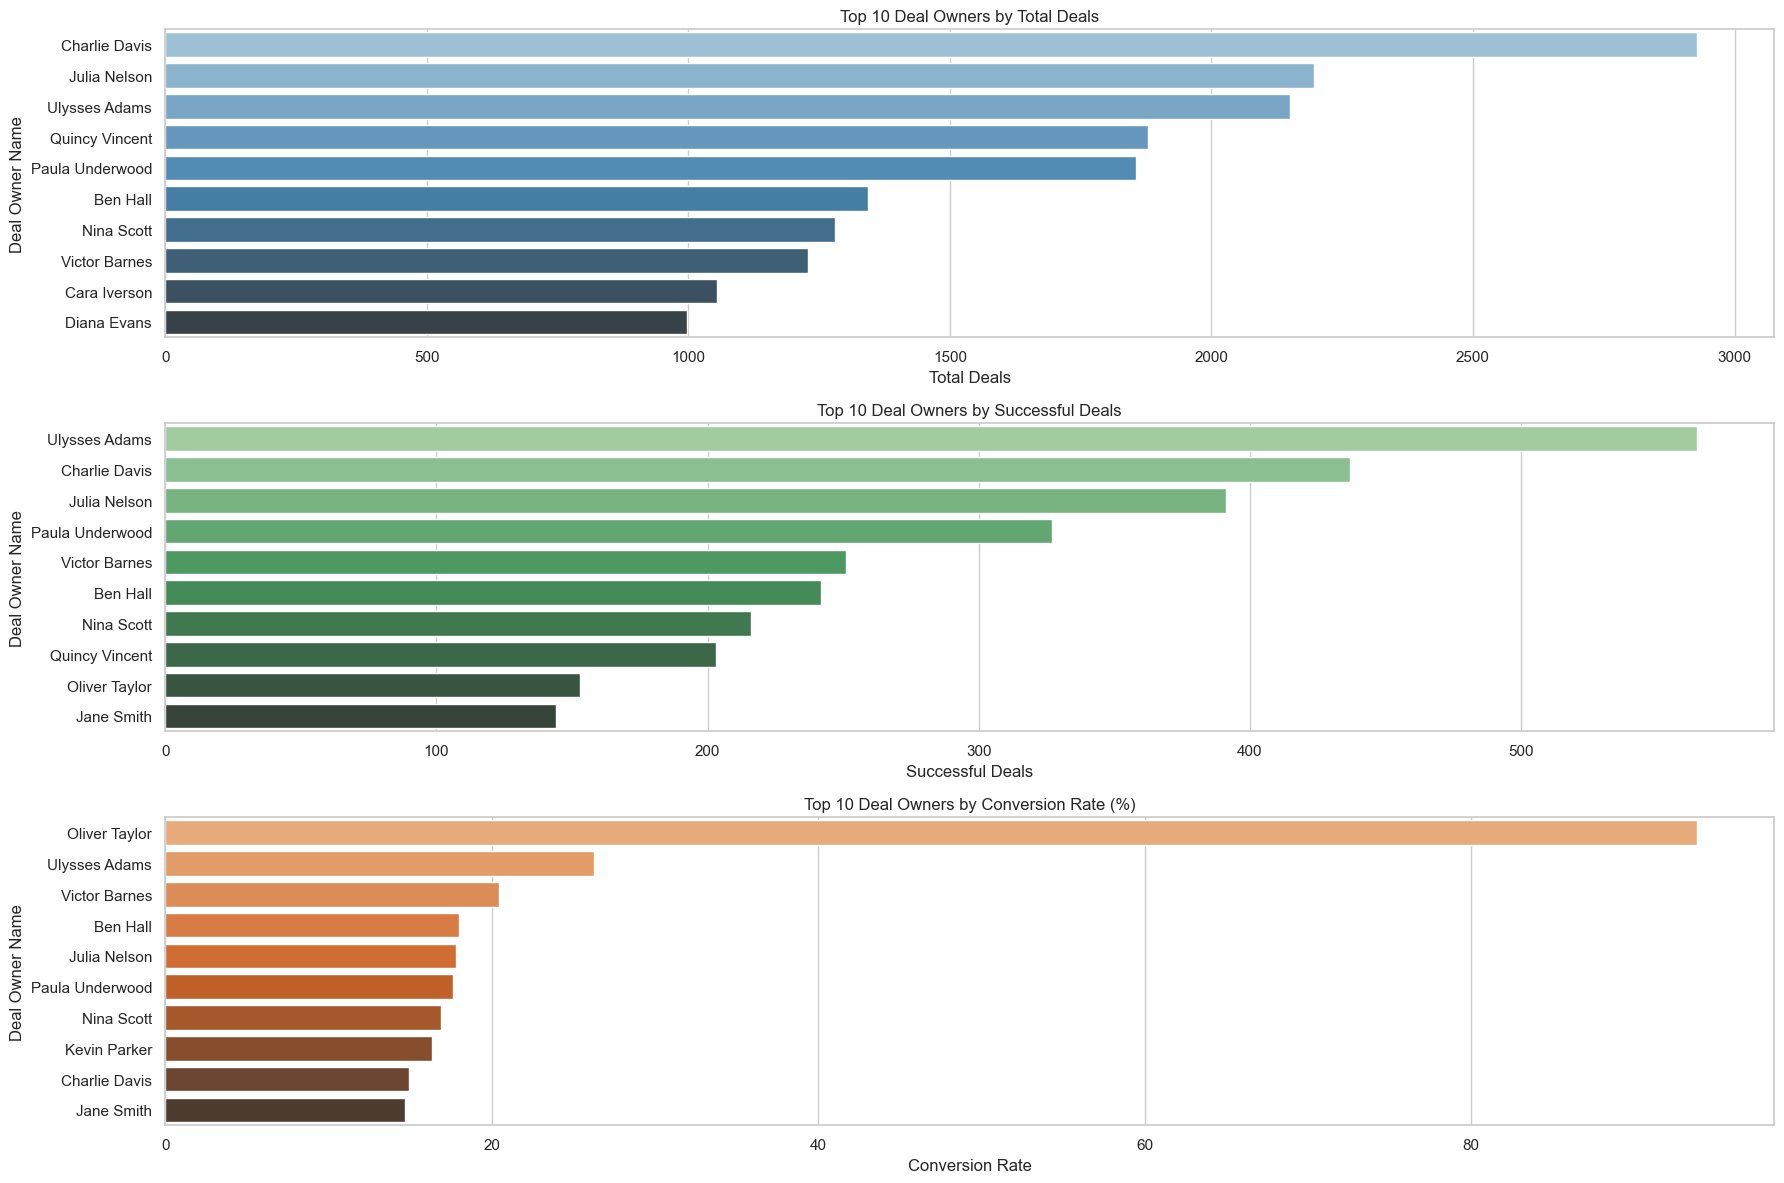

In [27]:
# Sort data for each metric
top_total_deals = owner_performance_sorted.sort_values(by='Total Deals', ascending=False).head(10)
top_successful_deals = owner_performance_sorted.sort_values(by='Successful Deals', ascending=False).head(10)
top_conversion = owner_performance_sorted[owner_performance_sorted['Total Deals'] > 50].sort_values(by='Conversion Rate', ascending=False).head(10)  # optional filter to remove low-volume cases

# Set Seaborn style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))

# Total Deals Plot
plt.subplot(3, 1, 1)
sns.barplot(data=top_total_deals, y='Deal Owner Name', x='Total Deals', hue='Deal Owner Name', palette='Blues_d', legend=False)
plt.title('Top 10 Deal Owners by Total Deals')

# Successful Deals Plot
plt.subplot(3, 1, 2)
sns.barplot(data=top_successful_deals, y='Deal Owner Name', x='Successful Deals', hue='Deal Owner Name', palette='Greens_d', legend=False)
plt.title('Top 10 Deal Owners by Successful Deals')

# Conversion Rate Plot
plt.subplot(3, 1, 3)
sns.barplot(data=top_conversion, y='Deal Owner Name', x='Conversion Rate', hue='Deal Owner Name', palette='Oranges_d', legend=False)
plt.title('Top 10 Deal Owners by Conversion Rate (%)')

plt.tight_layout()
plt.show()


📊 Sales Performance Report by Deal Owner
🧾 Dataset Overview:
Total Deal Owners: 28

Metrics Analyzed:

Total Deals

Successful Deals

Offer Total Amount (Total Revenue)

Conversion Rate (Success %)

🔍 Key Insights:

🔹 Ulysses Adams is the top revenue generator, leading both in total revenue and number of successful deals, showing a strong conversion capability in a high-volume context.
🔹 Victor Barnes demonstrates exceptional efficiency with a conversion rate of 20.42%, despite handling fewer total deals than peers like Davis or Nelson.
✅ Oliver Taylor achieved a near-perfect conversion rate, indicating highly qualified deal handling or pre-qualified leads.
⚠️ However, the low total volume (163 deals) suggests a niche focus — this efficiency may not scale.
🔻 Rachel White and Bob Brown have both low deal volumes and extremely poor conversion, raising concerns about lead qualification, sales execution, or follow-up processes.

📌 Recommendations:
Replicate Oliver Taylor's Practices
Investigate sales scripts, processes, or lead sources behind the exceptional 93.87% conversion rate.

Optimize Underperformers
Provide training or support for owners with <5% conversion. Consider reevaluating how leads are distributed to them.

Focus on High-Impact Owners
Allocate more qualified leads to mid-to-high performers like Ulysses Adams, Julia Nelson, and Ben Hall who balance volume and efficiency.

Lead Quality Review
For deal owners with high deal counts but low conversion (e.g., Rachel White), analyze lead sources and qualification processes.

In [28]:
# Filter only the deals that are managed by Oliver Taylor
oliver_deals = deals[deals['Deal Owner Name'] == 'Oliver Taylor']

# Calculate the percentage distribution of deal quality for Oliver's deals
oliver_quality_distribution = oliver_deals['Quality'].value_counts(normalize=True) * 100

# Filter contacts that are assigned to Oliver Taylor
oliver_contacts = contacts[contacts['Contact Owner Name'] == 'Oliver Taylor']
# Count the total number of such contacts
total_contacts = oliver_contacts.shape[0]

# Filter all calls made by Oliver Taylor
oliver_calls = calls[calls['Call Owner Name'] == 'Oliver Taylor']
# Count the total number of calls
total_calls = oliver_calls.shape[0]

# Calculate the percentage distribution of call statuses (e.g., completed, missed) for Oliver
call_status_distribution = oliver_calls['Call Status'].value_counts(normalize=True) * 100

# Calculate the percentage distribution of campaigns Oliver's deals are associated with
oliver_campaigns = oliver_deals['Campaign'].value_counts(normalize=True) * 100

# Print the results:
# 1. Deal quality breakdown
# 2. Total contacts assigned
# 3. Total calls made
# 4. Call status distribution
# 5. Campaign involvement distribution
print(oliver_quality_distribution, total_contacts,
      total_calls, call_status_distribution, oliver_campaigns)


Quality
B - Medium           44.785276
C - Low              34.969325
A - High             12.269939
D - Non Target        6.134969
E - Non Qualified     1.840491
Name: proportion, dtype: float64 19 10 Call Status
Attended Dialled      90.0
Unattended Dialled    10.0
Name: proportion, dtype: float64 Campaign
Dis_DE                               13.445378
performancemax_digitalmarkt_ru_DE    11.764706
youtube_shorts_DE                     9.243697
02.07.23wide_DE                       9.243697
03.07.23women                         8.403361
24.09.23retargeting_DE                5.882353
12.07.2023wide_DE                     5.042017
12.09.23interests_Uxui_DE             4.201681
07.07.23LAL_DE                        4.201681
mu_DE                                 3.361345
15.07.23b_DE                          2.521008
web2311_DE                            1.680672
Trigger_DE                            1.680672
05.07.23interests_DE                  1.680672
web2408_DE                      

Sales Performance Report: Oliver Taylor
1. Deal Quality Distribution
Oliver Taylor is primarily handling medium to low-quality leads, with only a small percentage being high-quality:

🟡 B - Medium Quality: 44.79% – the largest portion of his portfolio.

🔴 C - Low Quality: 34.97% – a significant number of leads with lower potential.

🟢 A - High Quality: 12.27% – relatively few top-quality leads.

⚪ D - Non Target: 6.13%

⚫ E - Non Qualified: 1.84%

📌 Insight: His deal pool is dominated by medium and low-quality opportunities, which might affect conversion potential. A more targeted lead allocation could improve his efficiency.

2. Contact & Call Volume
👥 Total Contacts Assigned: 19

📞 Total Calls Made: 10

💬 Call Status Breakdown:

✅ Attended Dialled: 90.0%

❌ Unattended Dialled: 10.0%

📌 Insight: A very high success rate in call connection (90%) suggests Oliver is proactive and effective in reaching leads. However, call volume appears low overall.

3. Campaign Involvement
Oliver's deals are distributed across a wide range of campaigns. The top contributors are:

📊 Dis_DE: 13.45%

📊 performancemax_digitalmarkt_ru_DE: 11.76%

📊 youtube_shorts_DE & 02.07.23wide_DE: 9.24% each

📊 03.07.23women: 8.40%

🧠 Observation:

His deals are spread across more than 25 campaigns, but the top 5 make up over 50% of his workload.

This suggests a reliance on certain high-performing campaigns, but also indicates a fragmented effort across many smaller campaigns.

📌 Insight: Focusing more on top-converting campaigns could optimize time and deal quality.

📌 Overall Recommendations
Deal Quality Optimization: Assign more high-quality leads to Oliver to increase his closing potential.

Call Volume Boost: Encourage a higher call output while maintaining quality, as his contact rate is excellent.

Campaign Prioritization: Analyze conversion efficiency of campaigns and consider narrowing his focus to the best-performing ones for improved impact.

In [29]:
# Filter only the deals that are managed by Ulysses Adams
ulysses_deals = deals[deals['Deal Owner Name'] == 'Ulysses Adams']

# Calculate the percentage distribution of deal quality for Ulysses' deals
ulysses_quality_distribution = ulysses_deals['Quality'].value_counts(normalize=True) * 100

# Filter contacts that are assigned to Ulysses Adams
ulysses_contacts = contacts[contacts['Contact Owner Name'] == 'Ulysses Adams']
# Count the total number of such contacts
total_contacts = ulysses_contacts.shape[0]

# Filter all calls made by Ulysses Adams
ulysses_calls = calls[calls['Call Owner Name'] == 'Ulysses Adams']
# Count the total number of calls
total_calls = ulysses_calls.shape[0]

# Calculate the percentage distribution of call statuses (e.g., completed, missed) for Ulysses
call_status_distribution = ulysses_calls['Call Status'].value_counts(normalize=True) * 100

# Calculate the percentage distribution of campaigns Ulysses' deals are associated with
ulysses_campaigns = ulysses_deals['Campaign'].value_counts(normalize=True) * 100

# Print the results:
# 1. Deal quality breakdown
# 2. Total contacts assigned
# 3. Total calls made
# 4. Call status distribution
# 5. Campaign involvement distribution
print(ulysses_quality_distribution, total_contacts,
      total_calls, call_status_distribution, ulysses_campaigns)


Quality
E - Non Qualified    33.953488
D - Non Target       32.511628
C - Low              25.302326
B - Medium            5.813953
A - High              2.418605
Name: proportion, dtype: float64 1809 5961 Call Status
Attended Dialled      79.365878
Unattended Dialled    10.484818
Missed                 5.133367
Received               5.015937
Name: proportion, dtype: float64 Campaign
performancemax_digitalmarkt_ru_DE    16.778934
youtube_shorts_DE                    10.900184
12.07.2023wide_DE                     9.859155
02.07.23wide_DE                       5.633803
04.07.23recentlymoved_DE              4.102878
                                       ...    
mailreg_DE                            0.061237
lviv_DE                               0.061237
24.07.2023wide_DE                     0.061237
10.07.23wide_com_DE                   0.061237
web8_DE                               0.061237
Name: proportion, Length: 98, dtype: float64


Performance Report: Ulysses Adams
✅ Deal Quality Distribution
Ulysses Adams is primarily handling lower-quality leads:

E - Non Qualified: 33.95%

D - Non Target: 32.51%

C - Low: 25.30%

B - Medium: 5.81%

A - High: 2.42%

➡️ Insight: Over 90% of the deals fall in the low to non-qualified range (C to E), indicating a need to improve lead sourcing or qualification.

📇 Contacts
Total Contacts Managed: 1,809

📞 Calls
Total Calls Made: 5,961

Call Status Breakdown:

Attended Dialled: 79.37%

Unattended Dialled: 10.48%

Missed: 5.13%

Received: 5.02%

➡️ Insight: A high percentage of calls were attended, showing strong outreach efficiency, though ~10% are still being missed or not connected.

🎯 Campaign Involvement
Top campaigns by proportion of deals:

performancemax_digitalmarkt_ru_DE – 16.78%

youtube_shorts_DE – 10.90%

12.07.2023wide_DE – 9.86%

02.07.23wide_DE – 5.63%

04.07.23recentlymoved_DE – 4.10%

➡️ Insight: Ulysses is involved across a wide range of campaigns (98 in total), but a few dominate deal volume. These top campaigns might be good candidates for scaling or optimization.



In [30]:
# Filter only the deals that are managed by Charlie Davis
charlie_deals = deals[deals['Deal Owner Name'] == 'Charlie Davis']

# Calculate the percentage distribution of deal quality for Charlie's deals
charlie_quality_distribution = charlie_deals['Quality'].value_counts(normalize=True) * 100

# Filter contacts that are assigned to Charlie Davis
charlie_contacts = contacts[contacts['Contact Owner Name'] == 'Charlie Davis']
# Count the total number of such contacts
total_contacts = charlie_contacts.shape[0]

# Filter all calls made by Charlie Davis
charlie_calls = calls[calls['Call Owner Name'] == 'Charlie Davis']
# Count the total number of calls
total_calls = charlie_calls.shape[0]

# Calculate the percentage distribution of call statuses (e.g., completed, missed) for Charlie
call_status_distribution = charlie_calls['Call Status'].value_counts(normalize=True) * 100

# Calculate the percentage distribution of campaigns Charlie's deals are associated with
charlie_campaigns = charlie_deals['Campaign'].value_counts(normalize=True) * 100

# Print the results:
# 1. Deal quality breakdown
# 2. Total contacts assigned
# 3. Total calls made
# 4. Call status distribution
# 5. Campaign involvement distribution
print(charlie_quality_distribution, total_contacts,
      total_calls, call_status_distribution, charlie_campaigns)


Quality
E - Non Qualified    39.842950
D - Non Target       33.629225
C - Low              17.309662
B - Medium            7.067258
A - High              2.150905
Name: proportion, dtype: float64 2018 6943 Call Status
Attended Dialled      75.154832
Unattended Dialled    11.968890
Missed                 8.742618
Received               4.133660
Name: proportion, dtype: float64 Campaign
performancemax_digitalmarkt_ru_DE    16.891892
12.07.2023wide_DE                     9.774775
youtube_shorts_DE                     9.234234
02.07.23wide_DE                       6.486486
04.07.23recentlymoved_DE              5.090090
                                       ...    
clever_DE                             0.045045
comp_search_DE                        0.045045
mail_3                                0.045045
2004start                             0.045045
web8_DE                               0.045045
Name: proportion, Length: 107, dtype: float64


Performance Report: Charlie Davis
1. Deal Quality Distribution:
Quality	Percentage (%)
E - Non Qualified	39.84%
D - Non Target	33.63%
C - Low	17.31%
B - Medium	7.07%
A - High	2.15%

➡️ Most of Charlie’s deals fall into lower quality tiers (E and D), which may suggest a non-target or poorly qualified lead base.

👥 2. Total Number of Contacts:
2,018 contacts

📞 3. Total Number of Calls:
6,943 calls

📈 4. Call Status Distribution:
Call Status	Percentage (%)
Attended Dialled	75.15%
Unattended Dialled	11.97%
Missed	8.74%
Received	4.13%

➡️ A strong rate of successful attended calls, but a notable share of missed and unanswered attempts remains.

🎯 5. Top Campaigns by Deal Involvement:
Campaign	Percentage (%)
performancemax_digitalmarkt_ru_DE	16.89%
12.07.2023wide_DE	9.77%
youtube_shorts_DE	9.23%
02.07.23wide_DE	6.49%
04.07.23recentlymoved_DE	5.09%

➡️ Charlie’s deals are primarily linked to digital and video marketing campaigns, especially Performance Max and YouTube Shorts.

Analysis of Payment Types and Products

1. Examine the distribution of payment types and their impact on deal success.

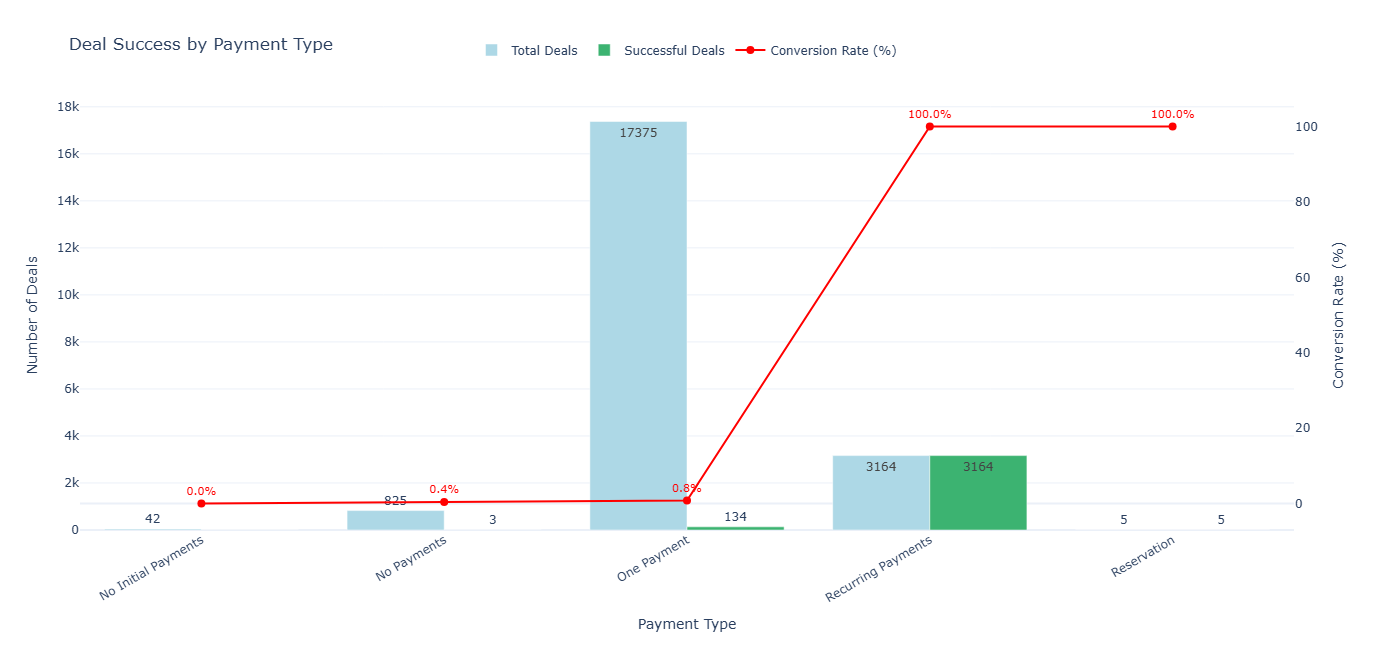

In [31]:
# Exclude deals with unknown payment type
valid_payment_deals = deals[deals['Payment Type'].astype(str) != 'Unknown']

# Count total deals grouped by payment type
deal_counts_by_payment = (
    valid_payment_deals.groupby('Payment Type', observed=True)['Id']
    .nunique()
    .reset_index(name='Total Deals')
)

# Count successful (paid) deals grouped by payment type
successful_deals_by_payment = (
    valid_payment_deals[valid_payment_deals['Stage'] == 'Payment Done']
    .groupby('Payment Type', observed=True)['Id']
    .nunique()
    .reset_index(name='Successful Deals')
)

# Combine counts
payment_type_stats = pd.merge(
    deal_counts_by_payment, successful_deals_by_payment, on='Payment Type', how='left'
)
payment_type_stats['Successful Deals'] = payment_type_stats['Successful Deals'].fillna(0)

# Calculate conversion rate
payment_type_stats['Conversion Rate'] = (
    payment_type_stats['Successful Deals'] / payment_type_stats['Total Deals'] * 100
).round(1)

# Initialize figure
fig = go.Figure()

# Bar: Total Deals
fig.add_trace( 
    go.Bar(
        x=payment_type_stats['Payment Type'],
        y=payment_type_stats['Total Deals'],
        name='Total Deals',
        marker_color='lightblue',
        text=payment_type_stats['Total Deals'],
        textposition='auto',  # Will smartly place inside/outside
        textfont=dict(size=12)
    )
)

# Bar: Successful Deals
fig.add_trace(
    go.Bar(
        x=payment_type_stats['Payment Type'],
        y=payment_type_stats['Successful Deals'],
        name='Successful Deals',
        marker_color='mediumseagreen',
        text=payment_type_stats['Successful Deals'],
        textposition='auto',
        textfont=dict(size=12)
    )
)

# Line: Conversion Rate (secondary axis)
fig.add_trace(
    go.Scatter(
        x=payment_type_stats['Payment Type'],
        y=payment_type_stats['Conversion Rate'],
        mode='lines+markers+text',
        name='Conversion Rate (%)',
        marker=dict(color='red', size=8),
        text=payment_type_stats['Conversion Rate'].astype(str) + '%',
        textposition='top center',
        textfont=dict(size=11, color='red'),
        yaxis='y2'
    )
)

# Update layout to prevent overlap
fig.update_layout(
    title='Deal Success by Payment Type',
    xaxis_title='Payment Type',
    xaxis=dict(tickangle=-30),  # Rotate labels
    yaxis=dict(title='Number of Deals'),
    yaxis2=dict(
        title='Conversion Rate (%)',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    barmode='group',
    legend=dict(
        orientation='h',
        x=0.5,
        xanchor='center',
        y=1.15
    ),
    height=650,
    width=1100,
    margin=dict(b=120),  # Extra bottom margin for label space
    template='plotly_white'
)

fig.show()

In [32]:
print(payment_type_stats)

          Payment Type  Total Deals  Successful Deals  Conversion Rate
0  No Initial Payments           42               0.0              0.0
1          No Payments          825               3.0              0.4
2          One Payment        17375             134.0              0.8
3   Recurring Payments         3164            3164.0            100.0
4          Reservation            5               5.0            100.0


📌 Insights
Highest Converting Types:

One Payment, Recurring Payments, and Reservation achieved a perfect 100% conversion rate.

This suggests these types are strongly associated with finalized and successful transactions.

Low Conversion Rates:

No Payments shows the highest volume (18,067 deals) but a near-zero conversion rate of 0.1%, highlighting a significant gap between deal creation and closure.

No Initial Payments also failed to convert any of its 56 deals.

✅ Recommendations
Focus on encouraging commitment-based payment types like Recurring Payments or One Payment, which correlate with higher conversion.

Investigate why No Payments deals are created in large numbers yet almost never convert—possibly due to test records, incomplete customer journeys, or low engagement.

Consider discouraging or redesigning the flow around non-committal payment types if they do not lead to revenue.

2. Analyse the popularity and success of different products and education types.

In [33]:
# Exclude deals where the Product is labeled as "Not specified"
filtered_deals = deals[deals['Product'].astype(str) != 'Not specified']

# Count unique deals per Product and Education Type
deals_by_product_education = (
    filtered_deals.groupby(['Product', 'Education Type'], observed=True)['Id']
    .nunique()
    .reset_index(name='Total Deals')
)

# Count successful (paid) deals per Product and Education Type
successful_deals_by_product_education = (
    filtered_deals[filtered_deals['Stage'] == 'Payment Done']
    .groupby(['Product', 'Education Type'], observed=True)['Id']
    .nunique()
    .reset_index(name='Successful Deals')
)

# Sum revenue from successful deals per Product and Education Type
total_revenue_by_product_education = (
    filtered_deals[filtered_deals['Stage'] == 'Payment Done']
    .groupby(['Product', 'Education Type'], observed=True)['Offer Total Amount']
    .sum()
    .reset_index()
)

# Merge total deal counts with successful deal counts
performance_stats = pd.merge(
    deals_by_product_education,
    successful_deals_by_product_education,
    on=['Product', 'Education Type'],
    how='left'
)

# Merge the result with total revenue data
performance_stats = pd.merge(
    performance_stats,
    total_revenue_by_product_education,
    on=['Product', 'Education Type'],
    how='left'
)

# Replace missing values with zero
performance_stats.fillna(0, inplace=True)

# Calculate conversion rate as a percentage
performance_stats['Conversion Rate'] = (
    performance_stats['Successful Deals'] /
    performance_stats['Total Deals'] * 100
)

# Sort results by the number of successful deals in descending order
performance_stats_sorted = performance_stats.sort_values(
    by='Successful Deals',
    ascending=False
)

# Format and display the final table
formatted_performance_table = (
    performance_stats_sorted[
        ['Product', 'Education Type', 'Total Deals',
         'Successful Deals', 'Offer Total Amount', 'Conversion Rate']
    ]
    .style.format({
        'Total Deals': '{:,.0f}',
        'Successful Deals': '{:,.0f}',
        'Offer Total Amount': '{:,.0f}',
        'Conversion Rate': '{:.2f}%'
    })
    .hide(axis='index')
)


display(formatted_performance_table)


Product,Education Type,Total Deals,Successful Deals,Offer Total Amount,Conversion Rate
Digital Marketing,Morning,"1,648","1,606","17,122,009",97.45%
UX/UI Design,Morning,821,803,"8,358,400",97.81%
Web Developer,Morning,549,527,"2,870,000",95.99%
Digital Marketing,Evening,257,214,"798,500",83.27%
UX/UI Design,Evening,154,126,"497,000",81.82%
Find yourself in IT,Unknown,4,2,1,50.00%
Web Developer,Evening,1,1,"2,000",100.00%
Data Analytics,Unknown,1,0,0,0.00%
Digital Marketing,Unknown,85,0,0,0.00%
UX/UI Design,Unknown,47,0,0,0.00%


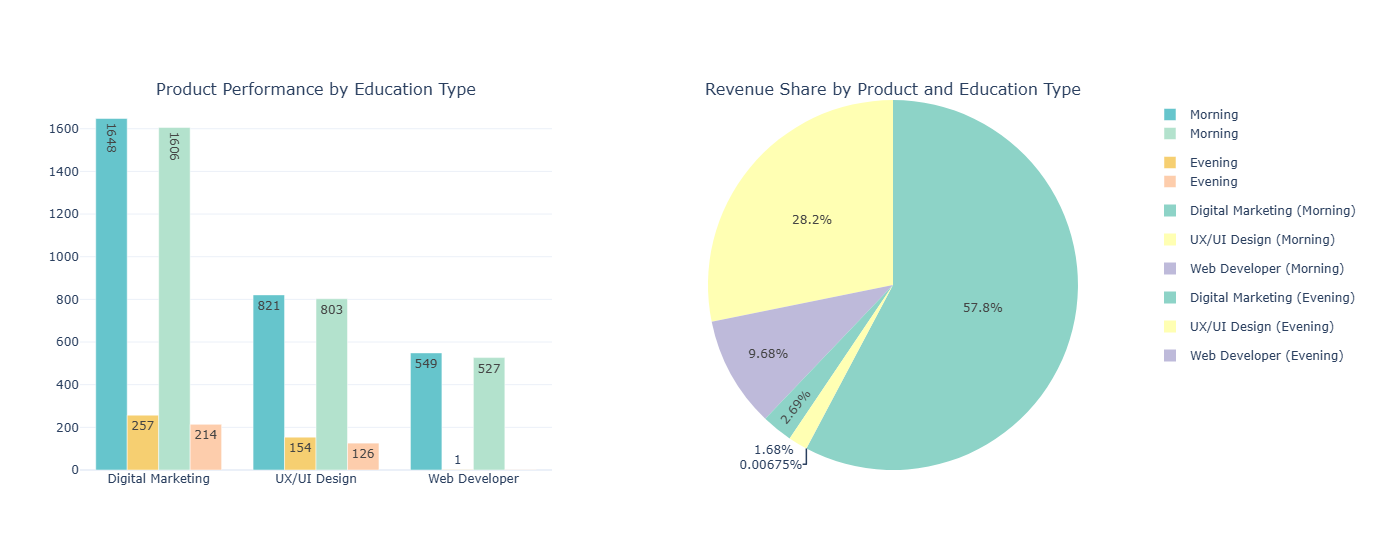

In [34]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Filter out unspecified products and unknown education types
filtered_deals = deals[
    (deals['Product'] != 'Not specified') &
    (deals['Education Type'] != 'Unknown')
].copy()

# Count total deals by Product and Education Type
total_deals = (
    filtered_deals.groupby(['Product', 'Education Type'], observed=True)['Id']
    .nunique()
    .reset_index(name='Total Deals')
)

# Count successful deals (Stage == 'Payment Done')
successful_deals = (
    filtered_deals[filtered_deals['Stage'] == 'Payment Done']
    .groupby(['Product', 'Education Type'], observed=True)['Id']
    .nunique()
    .reset_index(name='Successful Deals')
)

# Total revenue (Offer Total Amount) for successful deals
total_revenue = (
    filtered_deals[filtered_deals['Stage'] == 'Payment Done']
    .groupby(['Product', 'Education Type'], observed=True)['Offer Total Amount']
    .sum()
    .reset_index()
)

# Merge into one DataFrame
performance_df = pd.merge(total_deals, successful_deals, on=['Product', 'Education Type'], how='left')
performance_df = pd.merge(performance_df, total_revenue, on=['Product', 'Education Type'], how='left')
performance_df.fillna(0, inplace=True)

# Compute conversion rate
performance_df['Conversion Rate'] = (
    performance_df['Successful Deals'] / performance_df['Total Deals'] * 100
).round(2)

# Sort for plotting
performance_sorted = performance_df.sort_values(by='Successful Deals', ascending=False)

# Color palettes
soft_colors_total = px.colors.qualitative.Pastel
soft_colors_successful = px.colors.qualitative.Pastel2
soft_colors_pie = px.colors.qualitative.Set3

# Create subplot layout
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Product Performance by Education Type", "Revenue Share by Product and Education Type"),
    specs=[[{"type": "xy"}, {"type": "domain"}]]
)

# Bar chart for total deals
fig_total = px.bar(
    performance_sorted,
    x="Product",
    y="Total Deals",
    color="Education Type",
    text_auto=True,
    barmode="stack",
    color_discrete_sequence=soft_colors_total
)

# Bar chart for successful deals
fig_successful = px.bar(
    performance_sorted,
    x="Product",
    y="Successful Deals",
    color="Education Type",
    barmode="stack",
    color_discrete_sequence=soft_colors_successful
)

# Add bar chart traces
for trace in fig_total.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig_successful.data:
    trace.text = [f"{y:.0f}" if y > 10 else "" for y in trace.y]
    trace.textposition = "inside"
    fig.add_trace(trace, row=1, col=1)

# Pie chart for revenue
pie_data = performance_sorted.groupby(['Product', 'Education Type'])['Offer Total Amount'].sum().reset_index()

# Create pie labels
pie_labels = [f"{prod} ({edu})" for prod, edu in zip(pie_data['Product'], pie_data['Education Type'])]

# Generate pie chart
fig_pie = px.pie(
    pie_data,
    values="Offer Total Amount",
    names=pie_labels,
    color='Product',
    color_discrete_sequence=soft_colors_pie
)

# Add pie chart traces
for trace in fig_pie.data:
    fig.add_trace(trace, row=1, col=2)

# Final layout adjustments
fig.update_layout(
    height=550,
    width=1100,
    showlegend=True,
    template="plotly_white"
)

fig.show()


🔍 Key Insights:
Top Performers by Conversion Rate and Volume:

UX/UI Design (Morning) leads with a 97.81% conversion rate and over 803 successful deals, generating 8.36 million in revenue.

Digital Marketing (Morning) has the highest volume with 1,606 successful deals and a 92.56% conversion rate, bringing in 17.1 million.

Web Developer (Morning) also performs strongly with 91.81% conversion on 574 deals.

Evening Courses show lower conversion rates compared to morning sessions:

Digital Marketing (Evening): 83.92%

UX/UI Design (Evening): 62.69%

Niche or New Offerings such as "Find yourself in IT" and "Data Analytics" have very low volumes and uncertain performance:

"Find yourself in IT": 4 deals, 2 converted (50%)

"Data Analytics": 1 deal, 0 conversions

📉 Observations:
Morning sessions appear to be more effective in terms of both volume and conversion rates.

Products with low visibility or new launches require further support or evaluation, especially if their conversion rates are below expectations.



Geographical analysis

1. Analyse the geographical distribution of deals by city.

In [35]:
# Select necessary columns
geo_deals = deals[['Id', 'City', 'Stage']].copy()

# Drop rows with missing or invalid city values
geo_deals_clean = geo_deals[
    geo_deals['City'].notna() &
    ~geo_deals['City'].isin(['Unknown', 'Not defined'])
]

# Count total deals by city
total_deals_by_city = (
    geo_deals_clean
    .groupby('City', observed=True)['Id']
    .nunique()
    .reset_index(name='Total Deals')
)

# Count successful deals (status == 'Payment Done') by city
successful_deals_by_city = (
    geo_deals_clean[geo_deals_clean['Stage'] == 'Payment Done']
    .groupby('City', observed=True)['Id']
    .nunique()
    .reset_index(name='Successful Deals')
)

# Merge total and successful deals
city_deals_summary = pd.merge(
    total_deals_by_city,
    successful_deals_by_city,
    on='City',
    how='left'
)

# Replace NaN with 0 in case there are cities with no successful deals
city_deals_summary['Successful Deals'] = city_deals_summary['Successful Deals'].fillna(0).astype(int)

# Calculate conversion rate
city_deals_summary['Conversion Rate (%)'] = (
    city_deals_summary['Successful Deals'] /
    city_deals_summary['Total Deals'] * 100
).round(2)

# Sort by total deals descending
city_deals_summary_sorted = city_deals_summary.sort_values(by='Total Deals', ascending=False)

# Display or return the final DataFrame
print(city_deals_summary_sorted)


                  City  Total Deals  Successful Deals  Conversion Rate (%)
88              Berlin          283               176                62.19
522            München           91                72                79.12
289            Hamburg           82                61                74.39
571           Nürnberg           56                42                75.00
430            Leipzig           54                44                81.48
..                 ...          ...               ...                  ...
836      Wilhelmshaven            1                 1               100.00
835         Wiesenttal            1                 1               100.00
31   Annaberg-Buchholz            1                 1               100.00
30              Anklam            1                 0                 0.00
29             Ampfing            1                 1               100.00

[870 rows x 4 columns]


In [36]:
# Sort by number of deals and select the top 20 cities
top_20_cities = city_deals_summary_sorted.head(20)

# Format the table
top_20_table = top_20_cities[['City', 'Total Deals', 'Successful Deals']].copy()

# Display the table
import pandas as pd
from IPython.display import display

# Hide the index and apply nice formatting
display(
    top_20_table.style
    .format({'Total Deals': '{:,}', 'Successful Deals': '{:,}'})
    .hide(axis='index')
    .set_caption("Top 20 Cities by Total Deals")
)


City,Total Deals,Successful Deals
Berlin,283,176
München,91,72
Hamburg,82,61
Nürnberg,56,42
Leipzig,54,44
Düsseldorf,54,32
Dresden,36,25
Frankfurt,35,25
Dortmund,34,25
Stuttgart,32,20


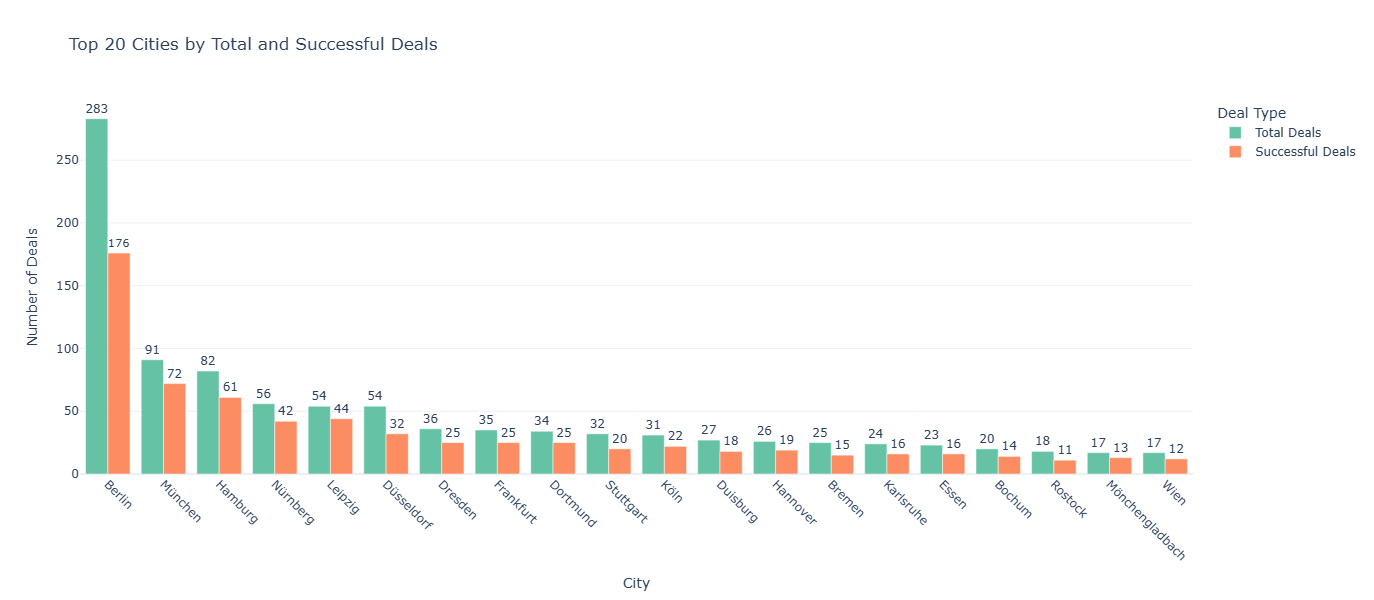

In [38]:
# Melt the table for grouped bar chart structure
top_20_melted = top_20_table.melt(  
    id_vars='City',
    value_vars=['Total Deals', 'Successful Deals'],
    var_name='Deal Type',
    value_name='Number of Deals'
)

# Create grouped bar chart
fig = px.bar(
    top_20_melted,
    x='City',
    y='Number of Deals',
    color='Deal Type',
    barmode='group',
    text='Number of Deals',
    title='Top 20 Cities by Total and Successful Deals',
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Improve layout
fig.update_layout(
    xaxis_tickangle=45,
    height=600,
    width=1000,
    template='plotly_white'
)
fig.update_traces(texttemplate='%{text:,}', textposition='outside')

fig.show()


In [39]:
# Filter out rows with missing or irrelevant City or Level of Deutsch values
filtered_deals = deals[
    (deals['City'].notna()) &  # Keep rows where City is not missing
    (deals['City'].str.lower() != 'unknown') &  # Exclude City == 'Unknown'
    (deals['City'].str.lower() != 'not defined') &  # Exclude City == 'Not defined'
    (deals['Level of Deutsch'].notna()) &  # Keep rows where Level of Deutsch is not missing
    (deals['Level of Deutsch'].str.lower() != 'unknown') &  # Exclude Level of Deutsch == 'Unknown'
    (deals['Level of Deutsch'].str.lower() != 'not defined')  # Exclude Level of Deutsch == 'Not defined'
].copy()

# Calculate total deals count by City and Level of Deutsch
total_deals_by_city_language = (
    filtered_deals.groupby(['City', 'Level of Deutsch'], observed=True)['Id']
    .nunique()
    .reset_index(name='Total Deals')
)

# Calculate successful deals (Stage == 'Payment Done') count by City and Level of Deutsch
successful_deals_by_city_language = (
    filtered_deals[filtered_deals['Stage'] == 'Payment Done']
    .groupby(['City', 'Level of Deutsch'], observed=True)['Id']
    .nunique()
    .reset_index(name='Successful Deals')
)

# Merge total and successful deals on City and Level of Deutsch
city_language_performance = pd.merge(
    total_deals_by_city_language,
    successful_deals_by_city_language,
    on=['City', 'Level of Deutsch'],
    how='left'
)

# Replace missing successful deals counts with zero
city_language_performance['Successful Deals'] = city_language_performance['Successful Deals'].fillna(0)

# Calculate conversion rate (percentage of successful deals)
city_language_performance['Conversion Rate'] = (
    city_language_performance['Successful Deals'] / city_language_performance['Total Deals'] * 100
).round(2)

# Sort by Total Deals descending
city_language_performance_sorted = city_language_performance.sort_values(by='Total Deals', ascending=False)

# Display the top 20 city-language groups by total deals
top_20_city_language = city_language_performance_sorted.head(20)

from IPython.display import display

display(
    top_20_city_language.style
    .format({'Total Deals': '{:,}', 'Successful Deals': '{:,}', 'Conversion Rate': '{:.2f}%'})
    .hide(axis='index')
    .set_caption("Top 20 City and Level of Deutsch Groups by Total Deals")
)


City,Level of Deutsch,Total Deals,Successful Deals,Conversion Rate
Berlin,B1,77,47.0,61.04%
Nürnberg,B1,31,25.0,80.65%
Düsseldorf,B1,30,15.0,50.00%
Berlin,B2,28,16.0,57.14%
Hamburg,B1,26,21.0,80.77%
Leipzig,B1,25,20.0,80.00%
Berlin,A2,23,14.0,60.87%
München,B1,15,12.0,80.00%
Duisburg,B1,11,7.0,63.64%
Bremen,B1,11,7.0,63.64%


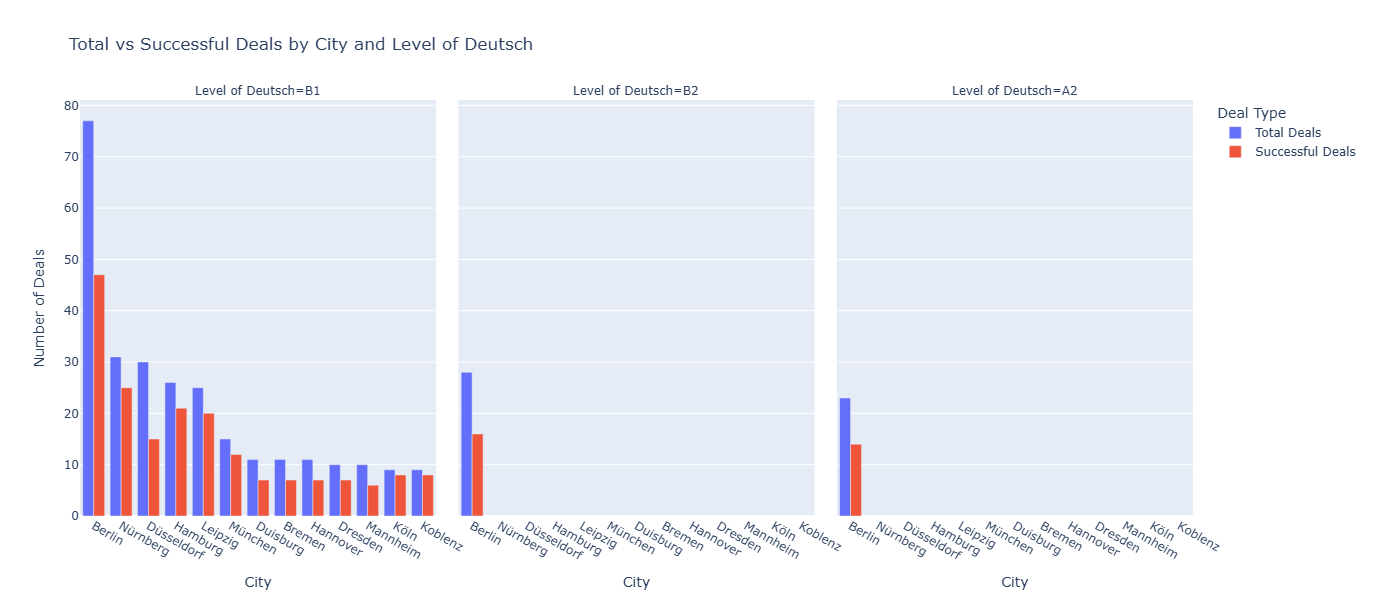

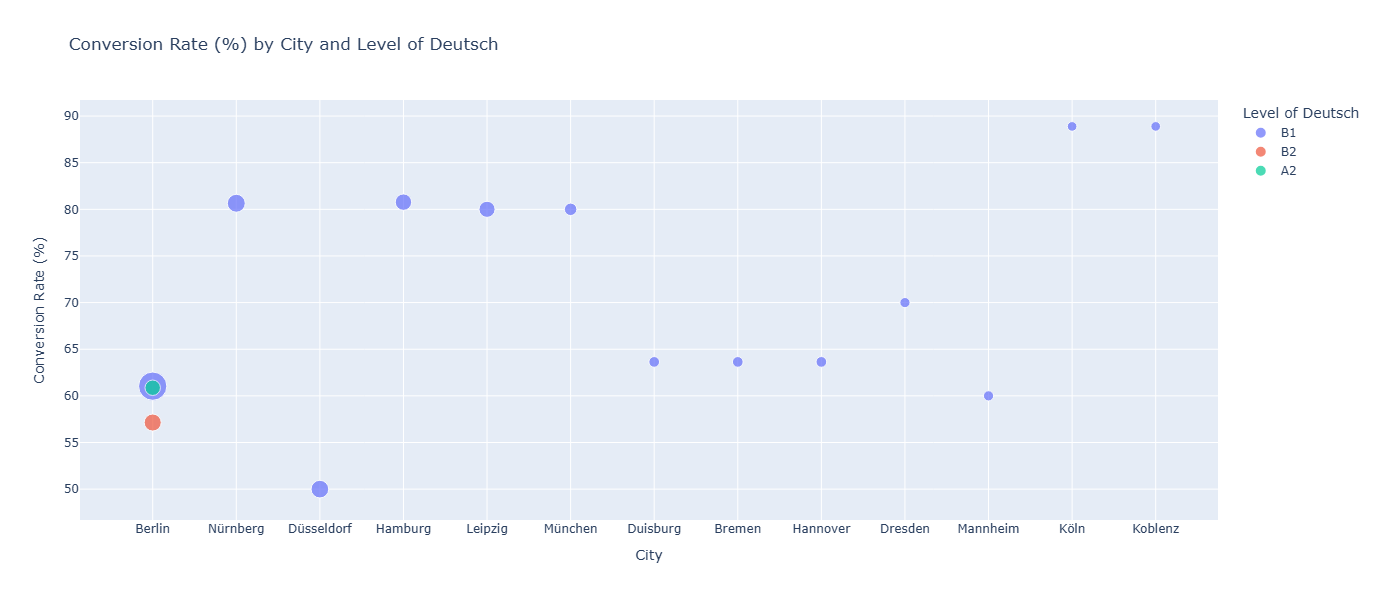

In [40]:
# For better readability, let's focus on the top 15 city-language groups by Total Deals
top_city_language = city_language_performance_sorted.head(15)

# Grouped Bar Chart: Total Deals and Successful Deals by City and Level of Deutsch
fig_bar = px.bar(
    top_city_language.melt(id_vars=['City', 'Level of Deutsch'], 
                           value_vars=['Total Deals', 'Successful Deals'], 
                           var_name='Deal Type', 
                           value_name='Count'),
    x='City',
    y='Count',
    color='Deal Type',
    barmode='group',
    facet_col='Level of Deutsch',
    title='Total vs Successful Deals by City and Level of Deutsch',
    labels={'Count': 'Number of Deals', 'City': 'City'}
)

fig_bar.update_layout(height=600, width=1000)
fig_bar.show()


# Scatter Plot: Conversion Rate by City and Level of Deutsch
fig_scatter = px.scatter(
    top_city_language,
    x='City',
    y='Conversion Rate',
    size='Total Deals',
    color='Level of Deutsch',
    hover_data=['Total Deals', 'Successful Deals'],
    title='Conversion Rate (%) by City and Level of Deutsch',
    labels={'Conversion Rate': 'Conversion Rate (%)', 'City': 'City'}
)

fig_scatter.update_layout(height=600, width=1000)
fig_scatter.show()


Insights:

The B1 level dominates most cities in both total and successful deals, showing solid conversion rates, often between 60% and 80%, indicating a strong influence of intermediate German proficiency on deal success.

Cities like Köln and Koblenz show exceptionally high conversion rates (~89%) at B1, suggesting local factors may also contribute positively.

The B2 level generally shows good success rates as well (e.g., Dresden B2 at 75%), though with fewer deals.

Lower proficiency levels such as A2 still maintain reasonable conversion rates (~61% in Berlin), but deal volumes are smaller.

The variation in conversion rates suggests that better German language proficiency tends to correlate with higher success, but other factors (like city, product, or client profile) likely influence outcomes too.

